Contents:
 1. Run MR-APSS at IV threshold 5e-05 (default) and evaluate the importance of MR-APSS for accounting for pleiotropy, sample structure, and selection bias.
 2. Run MR-APSS by changing the IV thresholds to show that MR-APSS is insensitive to IV thresholds.

# The function for calling MRAPSS() from MRAPSS package

In [3]:
run_APSS_func <- function(clumped=NULL,
                          exposure=NULL,
                          outcome=NULL,
                          C = diag(2),
                          Omega = matrix(0, 2, 2),
                          IV.Threshold = 5e-08, # IV selection threshold
                          Threshold = 5e-08,    # threshold for correcting for selection bias
                          Cor.SelectionBias=T){
  
 
  res=NULL
  
  for(i in 1:length(Threshold)){
    
    start = proc.time()
    if(!is.null(clumped)){
      
      test = subset(clumped, pval.exp <= IV.Threshold[i])
      if(nrow(test) < 4 ) next
      test$Threshold = Threshold[i]
      cat("IV selection threshold:", IV.Threshold[i] ,"\n")
      
      
      MRres = try(MRAPSS::MRAPSS(test,
                                 exposure=exposure,
                                 outcome=outcome,
                                 C= C,
                                 Omega= Omega,
                                 Cor.SelectionBias = Cor.SelectionBias))
 
      print(proc.time()-start)
      
      if(inherits(MRres, 'try-error')) {
        MRres=NULL
      }
    }
    
    
    res0 = data.frame(exposure = MRres$exposure,
                      outcome = MRres$outcome,
                      nSNP = nrow(MRres$MRdat),
                      pi0 = MRres$pi0,
                      nvalid = nrow(MRres$MRdat)*MRres$pi0,
                      sigma.sq= MRres$sigma.sq,
                      tau.sq= MRres$tau.sq,
                      beta = MRres$beta,
                      se = MRres$beta.se,
                      pval= MRres$pvalue,
                      method = MRres$method,
                      Threshold = Threshold[i],
                      IVstrength = MRres$IVsignal.sum
    )
    
    if(nrow(res0)!=0){
      res0$IV.Threshold = IV.Threshold[i]
    }
    
    res = rbind(res, res0)
    
  }
  
  return(res)
  
}



# Run MR-APSS at IV threshold 5e-05 (default)

In [3]:
# All the results will be saved to the file "NC_MRAPSS.MRres"
start = proc.time()
ts1 = c("AD", "ASD", "Daytime_Sleepiness", "Height_UKB",  "Intelligence", "RA",      
        "T2D", "Alcohol", "BMI", "Depression", "IBD", "MDD", "SCZ", "Angina", 
        "CAD", "HBP", "Income", "NEB", "Smoking", "Urate", "Anorexia", 
        "CD", "Height_GIANT", "Insomnia", "Neuroticism", "SWB")

ts2 = c("Hair_Light_Brown", "Hair_Dark_Brown",  "Hair_Black",    "Hair_Blonde",  "Tanning")

IV.Threshold = 5e-05

for( exposure in ts1){
  
  for( outcome in ts2){
    
    cat("Pair: ", exposure,"~", outcome,"\n")
    # read in GWAS summary data for IVs
    clumped = try(read.table(paste0("./MRdat/", exposure,"~",outcome), header = T))
    
    # read in background parameters Omega and C
    C = try(as.matrix(read.table(paste0("./pairs_bg_paras/",exposure, "~", outcome,"_C"),
                                 header = F)))
    
    C = matrix(C[nrow(C), ], 2,2)
    
    Omega = try(as.matrix(read.table(paste0("./pairs_bg_paras/", exposure, "~", outcome,"_Omega"),
                                     header = F)))
      
    Omega = matrix(Omega[nrow(Omega), ], 2, 2)
    
    if(inherits(clumped , 'try-error')) clumped = NULL
    if(inherits(C, 'try-error')) next
    if(inherits(Omega, 'try-error')) next
    if(nrow(clumped) < 4 ) next
    
    # The p-value threshold for selection bias correction
    Threshold =  ifelse(IV.Threshold==5e-05, unique(clumped$Threshold), IV.Threshold)
    
    # MR-APSS
    cat("Run MR-APSS ... \n")
    res = run_APSS_func(clumped = clumped,
                        exposure = exposure,
                        outcome = outcome,
                        C = C,
                        Omega=Omega,
                        IV.Threshold = IV.Threshold,
                        Threshold = Threshold,
                        Cor.SelectionBias = T)
    
    # MR-APSS(Omega=0)
    cat("Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... \n")
    res_Omega0 = run_APSS_func(clumped = clumped,
                               exposure = exposure,
                               outcome = outcome,
                               C = C,
                               Omega=matrix(0, 2, 2),
                               IV.Threshold = IV.Threshold,
                               Threshold = Threshold,
                               Cor.SelectionBias = T)
    res_Omega0$method = "MR-APSS(Omega=0)"
     
     # MR-APSS(C=I)
     cat("Run MR-APSS (C = I), i.e. MR-APSS not accounting for sample structure ... \n")
     res_CI = run_APSS_func(clumped = clumped,
                                exposure = exposure,
                                outcome = outcome,
                                C = diag(2),
                                Omega = Omega,
                                IV.Threshold = IV.Threshold,
                                Threshold = Threshold,
                                Cor.SelectionBias = T)
     res_CI$method = "MR-APSS(C=I)"
     
     # MR-APSS not accounting for selection bias
     cat("Run MR-APSS not accounting for selection bias ... \n")
     res_selec0 = run_APSS_func(clumped = clumped,
                            exposure = exposure,
                            outcome = outcome,
                            C = C,
                            Omega = Omega,
                            IV.Threshold = IV.Threshold,
                            Threshold = Threshold,
                            Cor.SelectionBias = F)
     res_selec0$method = "MR-APSS(Cor.SelectionBia=F)"
     
     # saving resuts
     write.table(res, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_Omega0, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_CI, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_selec0, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
}
  
}

print(proc.time()-start)


Pair:  AD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0187 , p-value =  7.1987e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.08942 . 
***********************************************************
   user  system elapsed 
  2.062   3.378   1.493 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0058 , beta.se =  0.0175 , p-value =  7.4077e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.68984 . 
***********************************************************
   user  system elapsed 
  1.095   0.728   0.911 
Run MR-APSS (C = I), i.e. MR-APSS not accounting for sample st

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.001 , beta.se =  0.0116 , p-value =  9.2870e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 30.622  19.263  24.949 
Pair:  AD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0 , beta.se =  0.0044 , p-value =  9.9758e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.04725 . 
***********************************************************
   user  system elapsed 
   0.93    0.53    0.73 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0027 , beta.se =  0.0133 , p-value =  8.3785e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.299   0.191   0.245 
Pair:  AD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.014 , beta.se =  0.0207 , p-value =  4.9808e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.15173 . 
***********************************************************
   user  system elapsed 
  1.434   0.899   1.166 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0089 , beta.se =  0.0132 , p-value =  4.9785e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 18.021  11.398  14.719 
Pair:  AD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0181 , beta.se =  0.0194 , p-value =  3.5122e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  16.80597 . 
***********************************************************
   user  system elapsed 
  1.396   0.891   1.144 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  A

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0018 , beta.se =  0.0124 , p-value =  8.8542e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.307   0.172   0.239 
Pair:  AD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0218 , beta.se =  0.0258 , p-value =  3.9880e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  17.07372 . 
***********************************************************
   user  system elapsed 
  7.232   4.668   5.954 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  AD  on  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0231 , beta.se =  0.015 , p-value =  1.2469e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 45.868  28.536  37.254 
Pair:  ASD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0171 , beta.se =  0.036 , p-value =  6.3410e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.99107 . 
***********************************************************
   user  system elapsed 
 16.836  10.533  13.728 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0074 , beta.se =  0.0102 , p-value =  4.6922e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  3.263   2.039   2.651 
Pair:  ASD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0117 , beta.se =  0.0492 , p-value =  8.1155e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.93972 . 
***********************************************************
   user  system elapsed 
 26.701  16.838  21.788 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR t

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0029 , beta.se =  0.0127 , p-value =  8.2034e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  0.550   0.289   0.420 
Pair:  ASD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  -0.0164 , beta.se =  0.0417 , p-value =  6.9367e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.99109 . 
***********************************************************
   user  system elapsed 
 22.629  13.841  18.247 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  -0.0031 , beta.se =  0.0115 , p-value =  7.8715e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
 17.240  10.762  14.268 
Pair:  ASD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0223 , beta.se =  0.0411 , p-value =  5.8683e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.97507 . 
***********************************************************
   user  system elapsed 
 16.557  10.722  14.061 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  -0.005 , beta.se =  0.011 , p-value =  6.5054e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  0.222   0.111   0.167 
Pair:  ASD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  0.7171 , beta.se =  0.4633 , p-value =  1.2170e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  1.016126 . 
***********************************************************
   user  system elapsed 
 11.622   7.269   9.725 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  ASD  o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  0.0108 , beta.se =  0.0179 , p-value =  5.4499e-01 . 
Total NO. of IVs=  39 , NO. of valid IVs with foreground signals:  38.9961 . 
***********************************************************
   user  system elapsed 
  1.028   0.640   0.834 
Pair:  Daytime_Sleepiness ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0709 , beta.se =  0.0516 , p-value =  1.6975e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  69.69107 . 
***********************************************************
   user  system elapsed 
 38.812  24.416  31.887 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0387 , beta.se =  0.0206 , p-value =  6.0403e-02 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 64.553  40.498  54.136 
Pair:  Daytime_Sleepiness ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1 , beta.se =  0.0535 , p-value =  6.1889e-02 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  70.09645 . 
***********************************************************
   user  system elapsed 
 11.125   6.982   9.419 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
******************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0565 , beta.se =  0.0234 , p-value =  1.5712e-02 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  241.9758 . 
***********************************************************
   user  system elapsed 
  1.224   0.835   1.030 
Pair:  Daytime_Sleepiness ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0614 , beta.se =  0.0677 , p-value =  3.6449e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  65.20411 . 
***********************************************************
   user  system elapsed 
  7.766   4.915   6.351 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0203 , beta.se =  0.0243 , p-value =  4.0329e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 15.018   9.283  12.157 
Pair:  Daytime_Sleepiness ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.06 , beta.se =  0.0688 , p-value =  3.8270e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  62.48233 . 
***********************************************************
   user  system elapsed 
  9.346   5.622   7.554 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.0314 , beta.se =  0.0238 , p-value =  1.8711e-01 . 
Total NO. of IVs=  243 , NO. of valid IVs with foreground signals:  242.9757 . 
***********************************************************
   user  system elapsed 
 11.433   7.211   9.359 
Pair:  Daytime_Sleepiness ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0198 , beta.se =  0.0661 , p-value =  7.6425e-01 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  66.92029 . 
***********************************************************
   user  system elapsed 
 42.664  26.611  35.773 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0281 , beta.se =  0.0264 , p-value =  2.8595e-01 . 
Total NO. of IVs=  242 , NO. of valid IVs with foreground signals:  241.9758 . 
***********************************************************
   user  system elapsed 
  1.172   0.692   0.934 
Pair:  Height_UKB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0057 , beta.se =  0.0092 , p-value =  5.3288e-01 . 
Total NO. of IVs=  2226 , NO. of valid IVs with foreground signals:  388.8473 . 
***********************************************************
   user  system elapsed 
 31.277   7.306  29.277 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0421 , beta.se =  0.0046 , p-value =  1.2792e-19 . 
Total NO. of IVs=  2226 , NO. of valid IVs with foreground signals:  2225.767 . 
***********************************************************
   user  system elapsed 
 86.606  18.399  83.713 
Pair:  Height_UKB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -8e-04 , beta.se =  0.0096 , p-value =  9.2945e-01 . 
Total NO. of IVs=  2224 , NO. of valid IVs with foreground signals:  384.6182 . 
***********************************************************
   user  system elapsed 
 28.164   6.237  26.778 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0366 , beta.se =  0.0056 , p-value =  7.2586e-11 . 
Total NO. of IVs=  2224 , NO. of valid IVs with foreground signals:  2223.766 . 
***********************************************************
   user  system elapsed 
 35.846   7.875  34.271 
Pair:  Height_UKB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.016 , beta.se =  0.011 , p-value =  1.4651e-01 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  392.0548 . 
***********************************************************
   user  system elapsed 
 33.289   8.012  31.221 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0701 , beta.se =  0.0056 , p-value =  1.4034e-36 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  2226.765 . 
***********************************************************
   user  system elapsed 
 64.871  13.618  61.980 
Pair:  Height_UKB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0117 , beta.se =  0.0102 , p-value =  2.4775e-01 . 
Total NO. of IVs=  2225 , NO. of valid IVs with foreground signals:  395.9658 . 
***********************************************************
   user  system elapsed 
 34.914   7.883  33.647 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0256 , beta.se =  0.005 , p-value =  2.4516e-07 . 
Total NO. of IVs=  2225 , NO. of valid IVs with foreground signals:  2224.768 . 
***********************************************************
   user  system elapsed 
 51.825  11.699  50.147 
Pair:  Height_UKB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0167 , beta.se =  0.0144 , p-value =  2.4796e-01 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  382.7249 . 
***********************************************************
   user  system elapsed 
 37.251   8.386  34.655 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0445 , beta.se =  0.0063 , p-value =  1.6045e-12 . 
Total NO. of IVs=  2227 , NO. of valid IVs with foreground signals:  2226.765 . 
***********************************************************
   user  system elapsed 
 46.130  10.699  43.028 
Pair:  Intelligence ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0797 , beta.se =  0.0252 , p-value =  1.5685e-03 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  69.4331 . 
***********************************************************
   user  system elapsed 
 17.792  10.748  15.049 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.011 , beta.se =  0.0083 , p-value =  1.8533e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
  2.112   1.050   2.848 
Pair:  Intelligence ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1092 , beta.se =  0.0539 , p-value =  4.2833e-02 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  51.68734 . 
***********************************************************
   user  system elapsed 
 13.966   7.294  11.959 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0525 , beta.se =  0.0106 , p-value =  6.9252e-07 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  400.9599 . 
***********************************************************
   user  system elapsed 
 37.320  19.088  32.608 
Pair:  Intelligence ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0832 , beta.se =  0.0583 , p-value =  1.5341e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  48.11368 . 
***********************************************************
   user  system elapsed 
 10.051   5.602   8.531 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0662 , beta.se =  0.0103 , p-value =  1.5159e-10 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
 48.123  26.536  41.864 
Pair:  Intelligence ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0033 , beta.se =  0.059 , p-value =  9.5608e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  39.436 . 
***********************************************************
   user  system elapsed 
  8.186   4.792   6.708 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0096 , beta.se =  0.0113 , p-value =  3.9875e-01 . 
Total NO. of IVs=  402 , NO. of valid IVs with foreground signals:  401.9598 . 
***********************************************************
   user  system elapsed 
  6.410   3.824   5.177 
Pair:  Intelligence ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0561 , beta.se =  0.0365 , p-value =  1.2426e-01 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  67.96917 . 
***********************************************************
   user  system elapsed 
238.640 131.756 205.499 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0747 , beta.se =  0.0113 , p-value =  3.7834e-11 . 
Total NO. of IVs=  401 , NO. of valid IVs with foreground signals:  400.9599 . 
***********************************************************
   user  system elapsed 
106.950  57.674  91.124 
Pair:  RA ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0237 , p-value =  5.6388e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  74.35368 . 
***********************************************************
   user  system elapsed 
  3.431   2.146   2.789 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0091 , beta.se =  0.0132 , p-value =  4.9247e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  1.924   1.231   1.577 
Pair:  RA ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0259 , beta.se =  0.0212 , p-value =  2.2232e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  81.41054 . 
***********************************************************
   user  system elapsed 
  3.283   2.044   2.664 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0199 , beta.se =  0.0134 , p-value =  1.3625e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.849   1.856   2.356 
Pair:  RA ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  0.004 , beta.se =  0.0214 , p-value =  8.5313e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  83.13053 . 
***********************************************************
   user  system elapsed 
  2.727   1.745   2.236 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  0.0034 , beta.se =  0.0138 , p-value =  8.0559e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  1.574   1.083   1.329 
Pair:  RA ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0355 , beta.se =  0.024 , p-value =  1.3951e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  76.51596 . 
***********************************************************
   user  system elapsed 
  3.294   2.045   2.673 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0261 , beta.se =  0.0148 , p-value =  7.7658e-02 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.067   1.350   1.711 
Pair:  RA ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  -0.0163 , beta.se =  0.0267 , p-value =  5.4083e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  80.54128 . 
***********************************************************
   user  system elapsed 
  3.245   1.955   2.604 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  RA 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  -0.013 , beta.se =  0.0161 , p-value =  4.1997e-01 . 
Total NO. of IVs=  135 , NO. of valid IVs with foreground signals:  134.9865 . 
***********************************************************
   user  system elapsed 
  2.059   1.302   1.681 
Pair:  T2D ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0033 , beta.se =  0.0144 , p-value =  8.1801e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  196.7693 . 
***********************************************************
   user  system elapsed 
 11.573   5.146  10.083 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -1e-04 , beta.se =  0.0042 , p-value =  9.8842e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9347 . 
***********************************************************
   user  system elapsed 
  8.391   3.787   7.226 
Pair:  T2D ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0019 , beta.se =  0.0186 , p-value =  9.1673e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  182.5653 . 
***********************************************************
   user  system elapsed 
 10.266   4.725   9.026 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  5e-04 , beta.se =  0.0094 , p-value =  9.5917e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9345 . 
***********************************************************
   user  system elapsed 
  3.175   1.515   2.753 
Pair:  T2D ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0193 , beta.se =  0.017 , p-value =  2.5816e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  194.6297 . 
***********************************************************
   user  system elapsed 
 12.099   5.286  10.471 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0207 , beta.se =  0.0094 , p-value =  2.7529e-02 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9346 . 
***********************************************************
   user  system elapsed 
  7.109   3.218   6.290 
Pair:  T2D ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0198 , p-value =  4.8947e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  178.716 . 
***********************************************************
   user  system elapsed 
 12.670   5.364  11.273 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0095 , p-value =  4.8033e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9345 . 
***********************************************************
   user  system elapsed 
  8.986   4.018   8.161 
Pair:  T2D ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  0.0029 , beta.se =  0.0183 , p-value =  8.7245e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  192.9963 . 
***********************************************************
   user  system elapsed 
 10.856   4.696   9.646 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  T

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  1e-04 , beta.se =  0.0047 , p-value =  9.8904e-01 . 
Total NO. of IVs=  652 , NO. of valid IVs with foreground signals:  651.9346 . 
***********************************************************
   user  system elapsed 
  9.276   4.110   8.561 
Pair:  Alcohol ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0982 , beta.se =  0.0482 , p-value =  4.1722e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  78.92478 . 
***********************************************************
   user  system elapsed 
 10.704   6.482   8.713 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0328 , beta.se =  0.0177 , p-value =  6.4443e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
 10.463   6.160   9.049 
Pair:  Alcohol ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1332 , beta.se =  0.0647 , p-value =  3.9482e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  72.03044 . 
***********************************************************
   user  system elapsed 
 10.229   6.260   8.341 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0549 , beta.se =  0.0211 , p-value =  9.4193e-03 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
  5.681   3.149   4.777 
Pair:  Alcohol ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0426 , beta.se =  0.051 , p-value =  4.0393e-01 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  82.75135 . 
***********************************************************
   user  system elapsed 
 16.091   9.864  13.518 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0319 , beta.se =  0.0192 , p-value =  9.7134e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
 25.854  15.637  22.012 
Pair:  Alcohol ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0666 , beta.se =  0.0569 , p-value =  2.4153e-01 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  73.91564 . 
***********************************************************
   user  system elapsed 
  8.989   5.437   7.706 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0482 , beta.se =  0.0196 , p-value =  1.3949e-02 . 
Total NO. of IVs=  343 , NO. of valid IVs with foreground signals:  342.9657 . 
***********************************************************
   user  system elapsed 
  9.136   5.658   7.533 
Pair:  Alcohol ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0241 , beta.se =  0.0736 , p-value =  7.4346e-01 . 
Total NO. of IVs=  342 , NO. of valid IVs with foreground signals:  70.91884 . 
***********************************************************
   user  system elapsed 
  7.733   4.748   6.281 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test re

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0935 , beta.se =  0.0249 , p-value =  1.7747e-04 . 
Total NO. of IVs=  342 , NO. of valid IVs with foreground signals:  341.9658 . 
***********************************************************
   user  system elapsed 
  8.249   4.542   8.119 
Pair:  BMI ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0213 , beta.se =  0.0218 , p-value =  3.2884e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  197.0567 . 
***********************************************************
   user  system elapsed 
 28.189   8.515  25.969 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  7e-04 , beta.se =  0.0073 , p-value =  9.2138e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 37.241  10.384  35.642 
Pair:  BMI ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0023 , beta.se =  0.026 , p-value =  9.2838e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  186.3865 . 
***********************************************************
   user  system elapsed 
 24.753   6.979  23.280 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0321 , beta.se =  0.0094 , p-value =  6.0706e-04 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 36.704  10.283  35.320 
Pair:  BMI ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.022 , beta.se =  0.0242 , p-value =  3.6311e-01 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  197.963 . 
***********************************************************
   user  system elapsed 
 30.897   9.156  29.073 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0202 , beta.se =  0.0085 , p-value =  1.7901e-02 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 57.793  16.968  55.067 
Pair:  BMI ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  -0.017 , beta.se =  0.0304 , p-value =  5.7666e-01 . 
Total NO. of IVs=  1300 , NO. of valid IVs with foreground signals:  169.6131 . 
***********************************************************
   user  system elapsed 
 31.978   9.072  30.503 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  0.0064 , beta.se =  0.0083 , p-value =  4.3661e-01 . 
Total NO. of IVs=  1300 , NO. of valid IVs with foreground signals:  1299.87 . 
***********************************************************
   user  system elapsed 
 58.729  16.395  55.162 
Pair:  BMI ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0798 , beta.se =  0.032 , p-value =  1.2714e-02 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  201.1114 . 
***********************************************************
   user  system elapsed 
 32.291   8.832  31.871 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  B

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0561 , beta.se =  0.0103 , p-value =  5.5190e-08 . 
Total NO. of IVs=  1301 , NO. of valid IVs with foreground signals:  1300.869 . 
***********************************************************
   user  system elapsed 
 46.305  12.572  43.126 
Pair:  Depression ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0948 , beta.se =  0.1066 , p-value =  3.7382e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  37.96413 . 
***********************************************************
   user  system elapsed 
 50.384  31.040  43.106 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0035 , beta.se =  0.0216 , p-value =  8.6944e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  0.952   0.585   0.769 
Pair:  Depression ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.071 , beta.se =  0.1153 , p-value =  5.3794e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  41.15287 . 
***********************************************************
   user  system elapsed 
 42.288  26.188  34.856 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0055 , beta.se =  0.025 , p-value =  8.2668e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
 36.778  23.120  29.988 
Pair:  Depression ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.1896 , beta.se =  0.1218 , p-value =  1.1946e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  34.58994 . 
***********************************************************
   user  system elapsed 
 51.503  31.524  42.021 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.0103 , beta.se =  0.0247 , p-value =  6.7563e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  0.944   0.697   0.820 
Pair:  Depression ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.1626 , beta.se =  0.11 , p-value =  1.3946e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  55.62668 . 
***********************************************************
   user  system elapsed 
 52.022  32.746  43.010 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.0316 , beta.se =  0.0236 , p-value =  1.7937e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  1.250   0.801   1.069 
Pair:  Depression ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  -0.3515 , beta.se =  0.5367 , p-value =  5.1250e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  6.319291 . 
***********************************************************
   user  system elapsed 
  7.907   4.989   7.001 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.0373 , beta.se =  0.0341 , p-value =  2.7403e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9803 . 
***********************************************************
   user  system elapsed 
  1.572   0.940   1.256 
Pair:  IBD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0013 , beta.se =  0.0101 , p-value =  8.9878e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.5501 . 
***********************************************************
   user  system elapsed 
  6.486   3.644   5.466 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  2e-04 , beta.se =  0.0056 , p-value =  9.6538e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  4.695   2.890   3.832 
Pair:  IBD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0043 , beta.se =  0.0138 , p-value =  7.5671e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.3124 . 
***********************************************************
   user  system elapsed 
  6.447   3.891   5.412 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  4e-04 , beta.se =  0.0072 , p-value =  9.5213e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  4.112   2.295   3.439 
Pair:  IBD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0131 , beta.se =  0.0122 , p-value =  2.8205e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  133.5265 . 
***********************************************************
   user  system elapsed 
  7.081   4.385   6.064 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0106 , beta.se =  0.0069 , p-value =  1.2567e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  6.999   4.163   5.953 
Pair:  IBD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0047 , beta.se =  0.0137 , p-value =  7.3240e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  131.6663 . 
***********************************************************
   user  system elapsed 
  6.838   3.939   5.995 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0026 , beta.se =  0.0072 , p-value =  7.1533e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  2.509   1.504   2.044 
Pair:  IBD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0082 , beta.se =  0.0124 , p-value =  5.0919e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  132.3326 . 
***********************************************************
   user  system elapsed 
  8.263   4.694   6.785 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  I

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0027 , beta.se =  0.0073 , p-value =  7.1384e-01 . 
Total NO. of IVs=  361 , NO. of valid IVs with foreground signals:  360.9639 . 
***********************************************************
   user  system elapsed 
  2.085   1.190   1.720 
Pair:  MDD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.1632 , beta.se =  0.1952 , p-value =  4.0320e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99699 . 
***********************************************************
   user  system elapsed 
 15.356   9.943  12.747 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0136 , beta.se =  0.0553 , p-value =  8.0564e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  1.611   1.018   1.315 
Pair:  MDD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.2841 , beta.se =  0.1882 , p-value =  1.3110e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99695 . 
***********************************************************
   user  system elapsed 
  4.280   2.784   3.533 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0758 , beta.se =  0.0582 , p-value =  1.9278e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  0.119   0.088   0.103 
Pair:  MDD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  -0.0016 , beta.se =  0.1704 , p-value =  9.9255e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99696 . 
***********************************************************
   user  system elapsed 
  5.039   3.040   4.041 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  0.0046 , beta.se =  0.0581 , p-value =  9.3727e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  0.121   0.087   0.104 
Pair:  MDD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.1048 , beta.se =  0.164 , p-value =  5.2281e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99711 . 
***********************************************************
   user  system elapsed 
 17.100  10.691  14.042 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0488 , beta.se =  0.0534 , p-value =  3.6149e-01 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
 18.671  11.505  15.107 
Pair:  MDD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  0.5392 , beta.se =  0.2565 , p-value =  3.5567e-02 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.99525 . 
***********************************************************
   user  system elapsed 
  4.993   3.176   4.090 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  MDD 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  0.1887 , beta.se =  0.0798 , p-value =  1.8005e-02 . 
Total NO. of IVs=  22 , NO. of valid IVs with foreground signals:  21.9978 . 
***********************************************************
   user  system elapsed 
  0.972   0.550   0.761 
Pair:  SCZ ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0066 , beta.se =  0.016 , p-value =  6.7964e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  153.8225 . 
***********************************************************
   user  system elapsed 
 38.237  16.948  33.703 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0134 , beta.se =  0.0059 , p-value =  2.2755e-02 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
121.444  48.848 109.870 
Pair:  SCZ ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0138 , beta.se =  0.0216 , p-value =  5.2350e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  147.8795 . 
***********************************************************
   user  system elapsed 
 42.571  17.394  37.585 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0188 , beta.se =  0.0068 , p-value =  5.9171e-03 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
 39.375  14.568  37.047 
Pair:  SCZ ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  -0.0025 , beta.se =  0.0167 , p-value =  8.8052e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  157.6666 . 
***********************************************************
   user  system elapsed 
245.600 103.904 221.359 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0057 , beta.se =  0.0066 , p-value =  3.8146e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
147.999  61.896 132.726 
Pair:  SCZ ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0137 , beta.se =  0.0213 , p-value =  5.2138e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  139.3764 . 
***********************************************************
   user  system elapsed 
 50.948  21.902  45.091 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  -0.0068 , beta.se =  0.0064 , p-value =  2.8432e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
  3.223   1.288   2.915 
Pair:  SCZ ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  7e-04 , beta.se =  0.0194 , p-value =  9.6946e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  136.3368 . 
***********************************************************
   user  system elapsed 
 13.583   5.501  12.572 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SC

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  0.0076 , beta.se =  0.0078 , p-value =  3.3051e-01 . 
Total NO. of IVs=  665 , NO. of valid IVs with foreground signals:  664.9335 . 
***********************************************************
   user  system elapsed 
 28.301  11.482  26.218 
Pair:  Angina ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.101 , beta.se =  0.0601 , p-value =  9.2854e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.98337 . 
***********************************************************
   user  system elapsed 
  2.405   1.557   1.982 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0661 , beta.se =  0.0286 , p-value =  2.0661e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  6.298   3.881   5.137 
Pair:  Angina ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0924 , beta.se =  0.0782 , p-value =  2.3751e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.08532 . 
***********************************************************
   user  system elapsed 
  1.475   1.037   1.256 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*******************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0445 , beta.se =  0.0357 , p-value =  2.1291e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  2.284   1.479   1.881 
Pair:  Angina ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0813 , beta.se =  0.0723 , p-value =  2.6129e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.44681 . 
***********************************************************
   user  system elapsed 
  1.844   1.162   1.604 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0766 , beta.se =  0.0335 , p-value =  2.2163e-02 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  4.317   2.704   3.511 
Pair:  Angina ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0378 , beta.se =  0.0605 , p-value =  5.3248e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  22.02842 . 
***********************************************************
   user  system elapsed 
  2.519   1.560   2.040 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0047 , beta.se =  0.0288 , p-value =  8.7082e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  5.665   3.650   4.706 
Pair:  Angina ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.1249 , beta.se =  0.0986 , p-value =  2.0514e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  23.48348 . 
***********************************************************
   user  system elapsed 
  1.809   1.163   1.485 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.0593 , beta.se =  0.0441 , p-value =  1.7871e-01 . 
Total NO. of IVs=  80 , NO. of valid IVs with foreground signals:  79.992 . 
***********************************************************
   user  system elapsed 
  1.034   0.578   0.805 
Pair:  CAD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0114 , beta.se =  0.0175 , p-value =  5.1532e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  146.4898 . 
***********************************************************
   user  system elapsed 
 14.506   9.086  11.891 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0089 , beta.se =  0.0151 , p-value =  5.5386e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
 15.613  10.099  13.665 
Pair:  CAD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0074 , beta.se =  0.0234 , p-value =  7.5289e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  139.8189 . 
***********************************************************
   user  system elapsed 
  7.264   4.798   6.143 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0025 , beta.se =  0.0193 , p-value =  8.9588e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  0.713   0.464   0.589 
Pair:  CAD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0269 , beta.se =  0.022 , p-value =  2.2243e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  144.6404 . 
***********************************************************
   user  system elapsed 
 10.671   6.651   8.678 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test resul

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0232 , beta.se =  0.0187 , p-value =  2.1391e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  4.095   2.623   3.360 
Pair:  CAD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0035 , beta.se =  0.0253 , p-value =  8.9060e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  130.4064 . 
***********************************************************
   user  system elapsed 
  5.302   3.444   4.384 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  -0.002 , beta.se =  0.0198 , p-value =  9.1805e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  1.836   1.148   1.492 
Pair:  CAD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  -0.0068 , beta.se =  0.0274 , p-value =  8.0274e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  143.8987 . 
***********************************************************
   user  system elapsed 
  7.748   4.996   6.377 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  C

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  -0.0042 , beta.se =  0.023 , p-value =  8.5603e-01 . 
Total NO. of IVs=  153 , NO. of valid IVs with foreground signals:  152.9847 . 
***********************************************************
   user  system elapsed 
  2.173   1.248   1.899 
Pair:  HBP ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0082 , beta.se =  0.0144 , p-value =  5.6893e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  189.462 . 
***********************************************************
   user  system elapsed 
 10.492   4.349  10.109 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0159 , beta.se =  0.0093 , p-value =  8.6239e-02 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9313 . 
***********************************************************
   user  system elapsed 
  2.732   1.345   2.359 
Pair:  HBP ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0069 , beta.se =  0.0214 , p-value =  7.4598e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  185.912 . 
***********************************************************
   user  system elapsed 
 19.749   8.148  17.969 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0196 , beta.se =  0.0114 , p-value =  8.6371e-02 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 20.414   8.138  18.482 
Pair:  HBP ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.013 , beta.se =  0.0197 , p-value =  5.0938e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  183.1409 . 
***********************************************************
   user  system elapsed 
 34.218  13.576  31.248 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  0.0013 , beta.se =  0.0109 , p-value =  9.0775e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9314 . 
***********************************************************
   user  system elapsed 
  3.251   1.267   2.962 
Pair:  HBP ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0093 , beta.se =  0.022 , p-value =  6.7361e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  182.1211 . 
***********************************************************
   user  system elapsed 
 14.819   5.951  13.545 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0148 , beta.se =  0.0109 , p-value =  1.7641e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 20.250   8.010  19.966 
Pair:  HBP ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0304 , beta.se =  0.0208 , p-value =  1.4476e-01 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  187.5262 . 
***********************************************************
   user  system elapsed 
 62.661  25.783  56.266 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0411 , beta.se =  0.0125 , p-value =  1.0019e-03 . 
Total NO. of IVs=  684 , NO. of valid IVs with foreground signals:  683.9312 . 
***********************************************************
   user  system elapsed 
 83.453  33.048  76.360 
Pair:  Income ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0209 , beta.se =  0.0543 , p-value =  6.9982e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  63.92506 . 
***********************************************************
   user  system elapsed 
 55.458  34.443  46.164 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.025 , beta.se =  0.0163 , p-value =  1.2482e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
 11.762   7.367  10.014 
Pair:  Income ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1946 , beta.se =  0.1038 , p-value =  6.0817e-02 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  39.54418 . 
***********************************************************
   user  system elapsed 
 12.470   7.704  10.273 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0831 , beta.se =  0.0222 , p-value =  1.8050e-04 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
  6.929   4.370   5.665 
Pair:  Income ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.02 , beta.se =  0.0642 , p-value =  7.5541e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  56.1299 . 
***********************************************************
   user  system elapsed 
 22.438  13.930  18.473 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.026 , beta.se =  0.0185 , p-value =  1.5892e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
 47.831  29.985  41.061 
Pair:  Income ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  0.0085 , beta.se =  0.0485 , p-value =  8.6064e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  59.52205 . 
***********************************************************
   user  system elapsed 
 11.442   7.223   9.343 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR tes

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0213 , beta.se =  0.0172 , p-value =  2.1606e-01 . 
Total NO. of IVs=  259 , NO. of valid IVs with foreground signals:  258.9741 . 
***********************************************************
   user  system elapsed 
  1.233   0.729   0.980 
Pair:  Income ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.1159 , beta.se =  0.08 , p-value =  1.4733e-01 . 
Total NO. of IVs=  257 , NO. of valid IVs with foreground signals:  57.1088 . 
***********************************************************
   user  system elapsed 
 19.625  12.251  16.107 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test result

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.0038 , beta.se =  0.0215 , p-value =  8.5821e-01 . 
Total NO. of IVs=  257 , NO. of valid IVs with foreground signals:  256.9743 . 
***********************************************************
   user  system elapsed 
 13.151   8.117  10.668 
Pair:  NEB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  2.5416 , beta.se =  1.5289 , p-value =  9.6442e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  2.463114 . 
***********************************************************
   user  system elapsed 
 24.087  14.933  19.829 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1041 , beta.se =  0.0433 , p-value =  1.6340e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  3.225   1.935   2.580 
Pair:  NEB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1812 , beta.se =  0.2044 , p-value =  3.7536e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.98916 . 
***********************************************************
   user  system elapsed 
 20.820  12.840  17.191 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.062 , beta.se =  0.0442 , p-value =  1.6121e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.9939 . 
***********************************************************
   user  system elapsed 
  0.294   0.188   0.241 
Pair:  NEB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  9.4513 , beta.se =  6.5119 , p-value =  1.4667e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  1.049738 . 
***********************************************************
   user  system elapsed 
 30.301  18.712  24.507 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  0.0339 , beta.se =  0.0834 , p-value =  6.8465e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  0.787   0.516   0.651 
Pair:  NEB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  -6.8197 , beta.se =  4.1065 , p-value =  9.6772e-02 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  1.026113 . 
***********************************************************
   user  system elapsed 
 18.147  11.707  14.927 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  -0.0758 , beta.se =  0.0797 , p-value =  3.4169e-01 . 
Total NO. of IVs=  62 , NO. of valid IVs with foreground signals:  61.9938 . 
***********************************************************
   user  system elapsed 
  0.801   0.491   0.646 
Pair:  NEB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  0.4618 , beta.se =  0.2652 , p-value =  8.1651e-02 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.11979 . 
***********************************************************
   user  system elapsed 
 58.400  37.265  48.372 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  NEB 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  0.0469 , beta.se =  0.053 , p-value =  3.7603e-01 . 
Total NO. of IVs=  61 , NO. of valid IVs with foreground signals:  60.9939 . 
***********************************************************
   user  system elapsed 
  7.919   5.180   6.576 
Pair:  Smoking ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  1e-04 , beta.se =  0.018 , p-value =  9.9355e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9093 . 
***********************************************************
   user  system elapsed 
 36.569  23.409  30.019 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.004 , beta.se =  0.0207 , p-value =  8.4519e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9858 . 
***********************************************************
   user  system elapsed 
  0.626   0.410   0.518 
Pair:  Smoking ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0388 , beta.se =  0.0549 , p-value =  4.7984e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9197 . 
***********************************************************
   user  system elapsed 
 38.942  24.613  31.889 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0184 , beta.se =  0.0241 , p-value =  4.4635e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9858 . 
***********************************************************
   user  system elapsed 
  0.553   0.379   0.467 
Pair:  Smoking ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0438 , beta.se =  0.0533 , p-value =  4.1113e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9288 . 
***********************************************************
   user  system elapsed 
 39.986  25.045  32.544 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0323 , beta.se =  0.0236 , p-value =  1.7177e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9858 . 
***********************************************************
   user  system elapsed 
  0.743   0.442   0.622 
Pair:  Smoking ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  -0.0052 , beta.se =  0.0513 , p-value =  9.1852e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9405 . 
***********************************************************
   user  system elapsed 
 40.620  25.522  33.106 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  -0.0068 , beta.se =  0.0226 , p-value =  7.6336e-01 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9858 . 
***********************************************************
   user  system elapsed 
 20.946  13.355  17.691 
Pair:  Smoking ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1858 , beta.se =  0.0641 , p-value =  3.7281e-03 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9506 . 
***********************************************************
   user  system elapsed 
165.906 105.177 137.495 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1036 , beta.se =  0.028 , p-value =  2.1647e-04 . 
Total NO. of IVs=  142 , NO. of valid IVs with foreground signals:  141.9858 . 
***********************************************************
   user  system elapsed 
 81.663  53.215  67.686 
Pair:  Urate ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0093 , beta.se =  0.0193 , p-value =  6.2930e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  73.0868 . 
***********************************************************
   user  system elapsed 
  2.768   1.728   2.248 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0034 , beta.se =  0.0156 , p-value =  8.2738e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  1.070   0.701   0.885 
Pair:  Urate ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.008 , beta.se =  0.0242 , p-value =  7.4225e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  72.57929 . 
***********************************************************
   user  system elapsed 
  2.413   1.629   2.023 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0017 , beta.se =  0.0192 , p-value =  9.3001e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  0.459   0.331   0.395 
Pair:  Urate ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0151 , beta.se =  0.0193 , p-value =  4.3373e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  75.64876 . 
***********************************************************
   user  system elapsed 
  5.478   3.552   5.158 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test r

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0119 , beta.se =  0.0161 , p-value =  4.5826e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  6.825   4.684   6.346 
Pair:  Urate ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0176 , beta.se =  0.0237 , p-value =  4.5859e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  69.35747 . 
***********************************************************
   user  system elapsed 
  2.605   1.697   2.165 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test res

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0116 , beta.se =  0.0185 , p-value =  5.2807e-01 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  1.387   0.868   1.127 
Pair:  Urate ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.043 , beta.se =  0.0251 , p-value =  8.6602e-02 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  74.59495 . 
***********************************************************
   user  system elapsed 
  3.623   2.377   3.000 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0386 , beta.se =  0.0206 , p-value =  6.0809e-02 . 
Total NO. of IVs=  93 , NO. of valid IVs with foreground signals:  92.9907 . 
***********************************************************
   user  system elapsed 
  2.051   1.216   1.636 
Pair:  Anorexia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0226 , beta.se =  0.0434 , p-value =  6.0216e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  48.52332 . 
***********************************************************
   user  system elapsed 
 36.267  23.592  30.601 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0197 , beta.se =  0.0125 , p-value =  1.1650e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 50.924  31.956  41.900 
Pair:  Anorexia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0645 , beta.se =  0.0491 , p-value =  1.8923e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  52.13669 . 
***********************************************************
   user  system elapsed 
 38.046  25.179  32.954 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0319 , beta.se =  0.0145 , p-value =  2.7068e-02 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 74.856  47.529  61.527 
Pair:  Anorexia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0494 , p-value =  8.9222e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  45.99179 . 
***********************************************************
   user  system elapsed 
 37.635  23.299  30.591 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  0.0052 , beta.se =  0.0143 , p-value =  7.1377e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 85.889  54.620  71.896 
Pair:  Anorexia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0193 , beta.se =  0.0417 , p-value =  6.4356e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  47.98292 . 
***********************************************************
   user  system elapsed 
 16.714  10.455  13.641 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0112 , beta.se =  0.0135 , p-value =  4.0445e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
 10.313   6.722   8.597 
Pair:  Anorexia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0297 , beta.se =  0.0597 , p-value =  6.1944e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  53.97787 . 
***********************************************************
   user  system elapsed 
 14.005   9.257  11.804 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR tes

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0201 , beta.se =  0.0176 , p-value =  2.5279e-01 . 
Total NO. of IVs=  114 , NO. of valid IVs with foreground signals:  113.9886 . 
***********************************************************
   user  system elapsed 
  3.896   2.520   3.208 
Pair:  CD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0082 , beta.se =  0.0095 , p-value =  3.8675e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.7294 . 
***********************************************************
   user  system elapsed 
  5.329   3.499   4.437 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR t

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0088 , beta.se =  0.0056 , p-value =  1.1262e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  5.047   3.072   4.060 
Pair:  CD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.01 , beta.se =  0.0132 , p-value =  4.5027e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  120.9248 . 
***********************************************************
   user  system elapsed 
  5.525   3.392   4.470 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0131 , beta.se =  0.0071 , p-value =  6.3481e-02 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  4.388   2.825   3.610 
Pair:  CD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0135 , beta.se =  0.013 , p-value =  2.9895e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.127 . 
***********************************************************
   user  system elapsed 
  5.801   3.590   4.799 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0085 , beta.se =  0.0067 , p-value =  2.0485e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  3.775   2.374   3.093 
Pair:  CD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0179 , beta.se =  0.0137 , p-value =  1.9244e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  118.6131 . 
***********************************************************
   user  system elapsed 
  6.223   3.774   5.230 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0104 , beta.se =  0.0071 , p-value =  1.4428e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  3.595   2.284   2.951 
Pair:  CD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0022 , beta.se =  0.0128 , p-value =  8.6668e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  119.401 . 
***********************************************************
   user  system elapsed 
  4.848   2.824   4.317 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  CD  o

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  -0.003 , beta.se =  0.0072 , p-value =  6.8060e-01 . 
Total NO. of IVs=  295 , NO. of valid IVs with foreground signals:  294.9705 . 
***********************************************************
   user  system elapsed 
  4.680   2.905   4.412 
Pair:  Height_GIANT ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0014 , beta.se =  0.0097 , p-value =  8.8376e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.0738 . 
***********************************************************
   user  system elapsed 
 18.055   5.589  16.946 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0256 , beta.se =  0.0057 , p-value =  5.6773e-06 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 34.412  10.104  31.949 
Pair:  Height_GIANT ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0052 , beta.se =  0.0141 , p-value =  7.1269e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  305.4967 . 
***********************************************************
   user  system elapsed 
 17.008   5.312  15.705 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0219 , beta.se =  0.0072 , p-value =  2.3894e-03 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 12.381   3.838  11.218 
Pair:  Height_GIANT ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0121 , p-value =  4.1336e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.4761 . 
***********************************************************
   user  system elapsed 
 18.689   5.886  18.020 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*****************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0457 , beta.se =  0.0067 , p-value =  8.0534e-12 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 23.635   6.997  22.529 
Pair:  Height_GIANT ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0192 , beta.se =  0.0127 , p-value =  1.2955e-01 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  310.4993 . 
***********************************************************
   user  system elapsed 
 19.959   5.975  18.402 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0204 , beta.se =  0.0064 , p-value =  1.3791e-03 . 
Total NO. of IVs=  1189 , NO. of valid IVs with foreground signals:  1188.879 . 
***********************************************************
   user  system elapsed 
 24.029   7.721  23.587 
Pair:  Height_GIANT ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0128 , beta.se =  0.0147 , p-value =  3.8184e-01 . 
Total NO. of IVs=  1188 , NO. of valid IVs with foreground signals:  310.2424 . 
***********************************************************
   user  system elapsed 
 19.684   5.771  19.096 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
****************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0359 , beta.se =  0.0076 , p-value =  2.1257e-06 . 
Total NO. of IVs=  1188 , NO. of valid IVs with foreground signals:  1187.879 . 
***********************************************************
   user  system elapsed 
 22.622   6.831  21.339 
Pair:  Insomnia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0343 , beta.se =  0.0485 , p-value =  4.7964e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  71.02485 . 
***********************************************************
   user  system elapsed 
 14.189   9.017  11.685 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0051 , beta.se =  0.0172 , p-value =  7.6548e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
  1.495   0.924   1.241 
Pair:  Insomnia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0372 , beta.se =  0.0569 , p-value =  5.1338e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  70.95057 . 
***********************************************************
   user  system elapsed 
140.319  88.077 116.333 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0023 , beta.se =  0.0203 , p-value =  9.1086e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
 35.820  21.937  30.839 
Pair:  Insomnia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0082 , beta.se =  0.0569 , p-value =  8.8575e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  71.55576 . 
***********************************************************
   user  system elapsed 
 97.757  60.352  81.004 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
*********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0179 , beta.se =  0.02 , p-value =  3.7049e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
 51.225  31.076  43.382 
Pair:  Insomnia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  0.0109 , beta.se =  0.0705 , p-value =  8.7733e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  66.25658 . 
***********************************************************
   user  system elapsed 
 34.684  21.059  27.973 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0103 , beta.se =  0.0196 , p-value =  5.9716e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
  1.972   1.141   1.677 
Pair:  Insomnia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0844 , p-value =  8.7130e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  67.73268 . 
***********************************************************
   user  system elapsed 
 13.584   8.425  11.351 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR te

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  -0.0027 , beta.se =  0.0249 , p-value =  9.1276e-01 . 
Total NO. of IVs=  348 , NO. of valid IVs with foreground signals:  347.9652 . 
***********************************************************
   user  system elapsed 
  8.201   5.320   6.780 
Pair:  Neuroticism ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0585 , beta.se =  0.0373 , p-value =  1.1678e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  120.3604 . 
***********************************************************
   user  system elapsed 
134.320  73.855 118.397 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0028 , beta.se =  0.0123 , p-value =  8.1744e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
  2.024   1.147   1.824 
Pair:  Neuroticism ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0913 , beta.se =  0.0645 , p-value =  1.5721e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  83.11642 . 
***********************************************************
   user  system elapsed 
 15.835   9.192  13.088 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0089 , beta.se =  0.0154 , p-value =  5.6427e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
 15.543   8.086  13.994 
Pair:  Neuroticism ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0231 , beta.se =  0.0503 , p-value =  6.4609e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  103.7847 . 
***********************************************************
   user  system elapsed 
  9.954   5.853   8.472 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
**********************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  0.0181 , beta.se =  0.0148 , p-value =  2.2191e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9537 . 
***********************************************************
   user  system elapsed 
 26.793  14.983  23.483 
Pair:  Neuroticism ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0374 , beta.se =  0.0602 , p-value =  5.3389e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  87.02711 . 
***********************************************************
   user  system elapsed 
 12.567   6.957  10.363 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0125 , beta.se =  0.015 , p-value =  4.0459e-01 . 
Total NO. of IVs=  462 , NO. of valid IVs with foreground signals:  461.9536 . 
***********************************************************
   user  system elapsed 
  8.400   4.361   7.929 
Pair:  Neuroticism ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0076 , beta.se =  0.0673 , p-value =  9.1020e-01 . 
Total NO. of IVs=  461 , NO. of valid IVs with foreground signals:  87.67748 . 
***********************************************************
   user  system elapsed 
 11.905   7.258   9.904 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0163 , beta.se =  0.0183 , p-value =  3.7548e-01 . 
Total NO. of IVs=  461 , NO. of valid IVs with foreground signals:  460.9537 . 
***********************************************************
   user  system elapsed 
  9.655   5.319   8.768 
Pair:  SWB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1249 , beta.se =  0.2568 , p-value =  6.2678e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  10.62471 . 
***********************************************************
   user  system elapsed 
 12.636   8.188  10.453 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
M

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0435 , beta.se =  0.0338 , p-value =  1.9753e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  0.295   0.168   0.231 
Pair:  SWB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -13.1674 , beta.se =  10.2765 , p-value =  2.0009e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  1.75141 . 
***********************************************************
   user  system elapsed 
 35.666  23.543  30.151 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0487 , beta.se =  0.051 , p-value =  3.3994e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  0.851   0.557   0.704 
Pair:  SWB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  -8.2335 , beta.se =  7.1776 , p-value =  2.5133e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  2.4697 . 
***********************************************************
   user  system elapsed 
 39.341  25.162  33.351 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  0.0312 , beta.se =  0.0422 , p-value =  4.5941e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  1.695   1.009   1.352 
Pair:  SWB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  11.4295 , beta.se =  11.2882 , p-value =  3.1129e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  2.300813 . 
***********************************************************
   user  system elapsed 
 40.795  26.260  33.977 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  -0.0058 , beta.se =  0.0402 , p-value =  8.8488e-01 . 
Total NO. of IVs=  65 , NO. of valid IVs with foreground signals:  64.9935 . 
***********************************************************
   user  system elapsed 
  1.282   0.785   1.033 
Pair:  SWB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.1555 , beta.se =  0.2976 , p-value =  6.0137e-01 . 
Total NO. of IVs=  64 , NO. of valid IVs with foreground signals:  8.658149 . 
***********************************************************
   user  system elapsed 
  8.418   5.054   6.769 
Run MR-APSS (Omega = 0), i.e. MR-APSS not accounting for polygenicity and pleiotropy. ... 
IV selection threshold: 5e-05 
***********************************************************
MR test results of  SWB

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.0333 , beta.se =  0.0433 , p-value =  4.4251e-01 . 
Total NO. of IVs=  64 , NO. of valid IVs with foreground signals:  63.9936 . 
***********************************************************
   user  system elapsed 
  0.305   0.156   0.233 
     user    system   elapsed 
10512.427  5442.447  9139.462 


# Q-Q plots

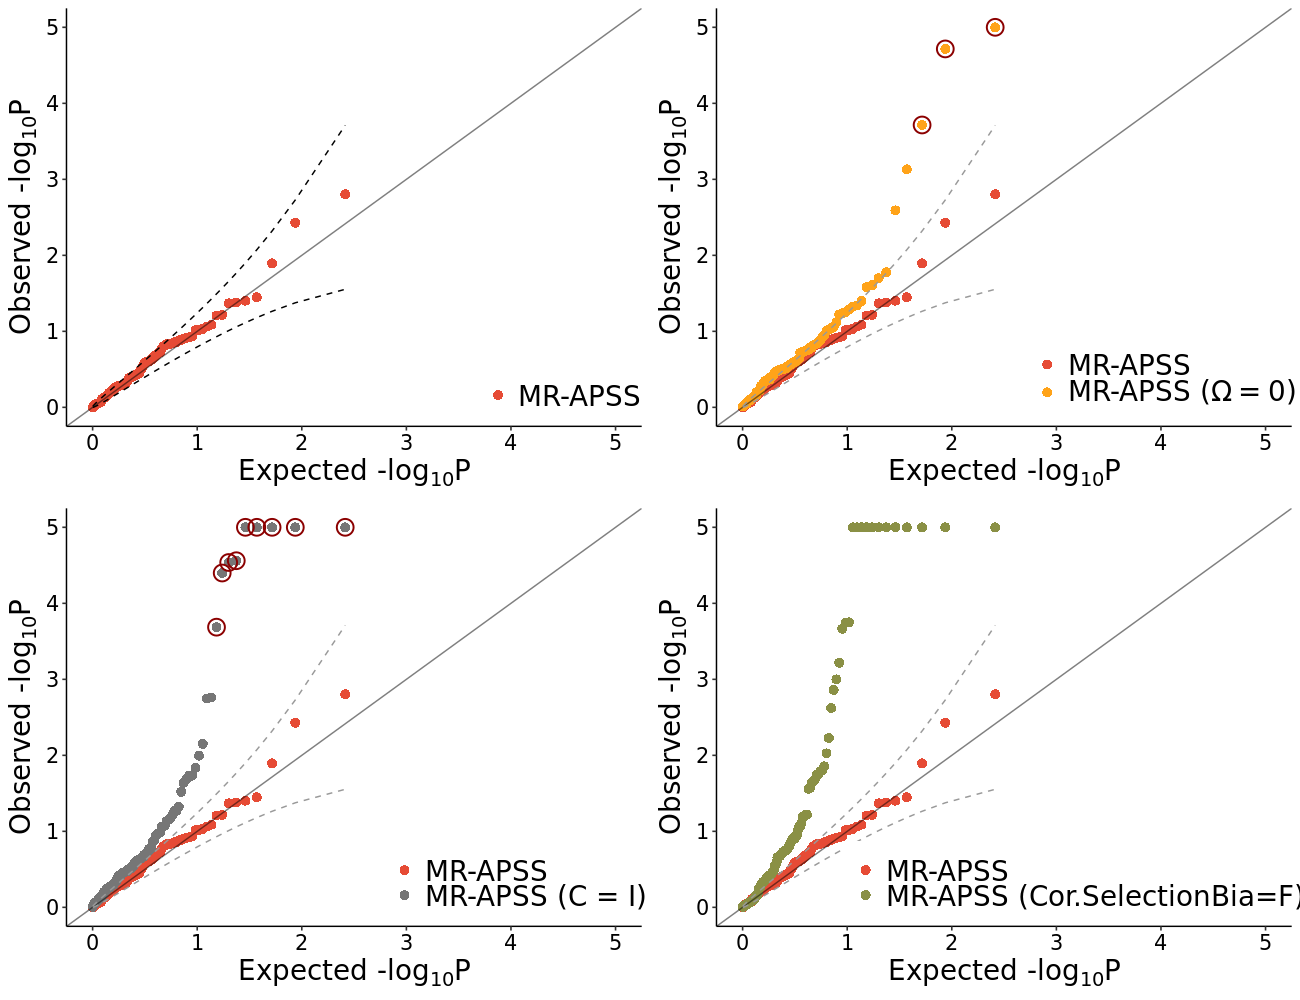

In [8]:
# Load packages
library(latex2exp)
library(gridExtra)
library(ggplot2)
library(ggpubr)

# Load QQ-plots functions
source('qqplot_funcs.R')

apss_res = read.table("NC_MRAPSS.MRres", header = F)
colnames(apss_res) = c("exposure","outcome", "nsnp","pi","nvalid","sigma.sq","tau.sq","b","se","pval",
                        "Method", "cor.Threshold", "IVstrength", "Threshold")
apss_res = subset(apss_res, Threshold==5e-05)
apss_res_dcast = na.omit(reshape2::dcast(unique(apss_res), exposure + outcome ~ Method, value.var = "pval", drop = T))

p1 = qqplot1(apss_res_dcast , "MR-APSS", max=5)+
  scale_color_manual(values = c("#E64B35FF"),
                     labels = list(TeX("MR-APSS"))) 

p2 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(Omega=0)", max=5) +
  scale_color_manual(values = c("#E64B35FF", "#FFA319FF"),
                     labels = list("MR-APSS", TeX("MR-APSS ($\\Omega = 0$)"))) 

p3 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(C=I)", max=5) +
  scale_color_manual(values = c("#E64B35FF", "#767676FF"),
                     labels = list("MR-APSS", "MR-APSS (C = I)")) 

p4 = qqplot2(apss_res_dcast , "MR-APSS", "MR-APSS(Cor.SelectionBia=F)", max=5, mark=F) +
  scale_color_manual(values = c("#E64B35FF", "#8A9045FF"),
                     labels = list("MR-APSS", "MR-APSS (Cor.SelectionBia=F)"))

options(repr.plot.width = 13, repr.plot.height = 10, repr.plot.res = 100)
grid.arrange(p1,p2,p3,p4, layout_matrix = matrix(c(1,2,3,4), ncol =2, byrow = T))

# Run MR-APSS changing the IV threshold

In [5]:
# All the results will be saved to the file "NC_MRAPSS.MRres"
start = proc.time()
ts1 = c("AD", "ASD", "Daytime_Sleepiness", "Height_UKB",  "Intelligence", "RA",      
        "T2D", "Alcohol", "BMI", "Depression", "IBD", "MDD", "SCZ", "Angina", 
        "CAD", "HBP", "Income", "NEB", "Smoking", "Urate", "Anorexia", 
        "CD", "Height_GIANT", "Insomnia", "Neuroticism", "SWB")

ts2 = c("Hair_Light_Brown", "Hair_Dark_Brown",  "Hair_Black",    "Hair_Blonde",  "Tanning")

IV.Threshold = c(5e-06,5e-07, 5e-08)

for( exposure in ts1){
  
  for( outcome in ts2){
    
    cat("Pair: ", exposure,"~", outcome,"\n")
    # read in GWAS summary data for IVs
    clumped = try(read.table(paste0("./MRdat/", exposure,"~",outcome), header = T))
    
    # read in background parameters Omega and C
    C = try(as.matrix(read.table(paste0("./pairs_bg_paras/",exposure, "~", outcome,"_C"),
                                 header = F)))
    
    C = matrix(C[nrow(C), ], 2,2)
    
    Omega = try(as.matrix(read.table(paste0("./pairs_bg_paras/", exposure, "~", outcome,"_Omega"),
                                     header = F)))
      
    Omega = matrix(Omega[nrow(Omega), ], 2, 2)
    
    if(inherits(clumped , 'try-error')) clumped = NULL
    if(inherits(C, 'try-error')) next
    if(inherits(Omega, 'try-error')) next
    if(nrow(clumped) < 4 ) next
    
    # The p-value threshold for selection bias correction
    Threshold =  ifelse(IV.Threshold==5e-05, unique(clumped$Threshold), IV.Threshold)
    
    # MR-APSS
    cat("Run MR-APSS ... \n")
    res = run_APSS_func(clumped = clumped,
                        exposure = exposure,
                        outcome = outcome,
                        C = C,
                        Omega=Omega,
                        IV.Threshold = IV.Threshold,
                        Threshold = Threshold,
                        Cor.SelectionBias = T)
    
     
     # MR-APSS not accounting for selection bias
     cat("Run MR-APSS not accounting for selection bias ... \n")
     res_selec0 = run_APSS_func(clumped = clumped,
                            exposure = exposure,
                            outcome = outcome,
                            C = C,
                            Omega = Omega,
                            IV.Threshold = IV.Threshold,
                            Threshold = Threshold,
                            Cor.SelectionBias = F)
     res_selec0$method = "MR-APSS(Cor.SelectionBia=F)"
     
#      # saving resuts
     write.table(res, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
     write.table(res_selec0, "NC_MRAPSS.MRres", quote=F, col.names = F, append = T,row.names = F)
     
}
  
}

print(proc.time()-start)

Pair:  AD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0065 , beta.se =  0.0194 , p-value =  7.3711e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  14.10276 . 
***********************************************************
   user  system elapsed 
  0.647   0.206   0.428 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -9e-04 , beta.se =  0.0202 , p-value =  9.6452e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  11.26786 . 
***********************************************************
   user  system elapsed 
 10.843   3.212   7.029 
IV selection threshold: 5e-08 
***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -2e-04 , beta.se =  0.0153 , p-value =  9.8809e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  23.9976 . 
***********************************************************
   user  system elapsed 
  3.457   0.944   2.201 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0114 , beta.se =  0.0171 , p-value =  5.0541e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
 13.594   4.219   8.909 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0035 , beta.se =  0.0192 , p-value =  8.5386e-01 . 
Total NO. of IVs=  10 , NO. of valid IVs with foreground signals:  9.999 . 
***********************************************************
   user  system elapsed 
 13.476   4.164   8.822 
Pair:  AD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0012 , beta.se =  0.0211 , p-value =  9.5652e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  14.02162 . 
***********************************************************
   user  system elapsed 
  2.043   0.577   1.310 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0067 , beta.se =  0.0226 , p-val

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0032 , beta.se =  0.0178 , p-value =  8.5564e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  23.9976 . 
***********************************************************
   user  system elapsed 
  8.437   2.559   5.501 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0056 , beta.se =  0.0192 , p-value =  7.7196e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
 16.837   5.059  10.951 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.011 , beta.se =  0.0216 , p-value =  6.1260e-01 . 
Total NO. of IVs=  10 , NO. of valid IVs with foreground signals:  9.999 . 
***********************************************************
   user  system elapsed 
 11.975   3.784   7.881 
Pair:  AD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.012 , beta.se =  0.0215 , p-value =  5.7695e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  14.1271 . 
***********************************************************
   user  system elapsed 
  9.229   2.924   6.077 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0063 , beta.se =  0.0227 , p-value =  7.8185e-01 . 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0093 , beta.se =  0.0177 , p-value =  5.9964e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  23.9976 . 
***********************************************************
   user  system elapsed 
 20.493   6.435  13.465 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0159 , beta.se =  0.0193 , p-value =  4.0834e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
 19.675   6.424  13.050 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Black : 
MR-APSS: beta =  0.0019 , beta.se =  0.0217 , p-value =  9.2949e-01 . 
Total NO. of IVs=  10 , NO. of valid IVs with foreground signals:  9.999 . 
***********************************************************
   user  system elapsed 
 13.627   4.322   8.976 
Pair:  AD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0208 , beta.se =  0.02 , p-value =  2.9778e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  13.88661 . 
***********************************************************
   user  system elapsed 
  0.608   0.173   0.390 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0254 , beta.se =  0.0211 , p-value =  2.3007e-01 . 
To

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0108 , beta.se =  0.0166 , p-value =  5.1491e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  23.9976 . 
***********************************************************
   user  system elapsed 
  0.158   0.039   0.099 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.016 , beta.se =  0.0179 , p-value =  3.6996e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
 24.983   7.475  16.233 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Hair_Blonde : 
MR-APSS: beta =  0.0261 , beta.se =  0.0202 , p-value =  1.9713e-01 . 
Total NO. of IVs=  10 , NO. of valid IVs with foreground signals:  9.999 . 
***********************************************************
   user  system elapsed 
 18.509   5.511  12.012 
Pair:  AD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.021 , beta.se =  0.0272 , p-value =  4.3959e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  14.13979 . 
***********************************************************
   user  system elapsed 
  2.396   0.718   1.558 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0156 , beta.se =  0.0297 , p-value =  6.0018e-01 . 
Total NO. of

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0297 , beta.se =  0.0211 , p-value =  1.5914e-01 . 
Total NO. of IVs=  24 , NO. of valid IVs with foreground signals:  23.9976 . 
***********************************************************
   user  system elapsed 
  5.418   1.561   3.490 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.025 , beta.se =  0.0251 , p-value =  3.1993e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  0.871   0.275   0.573 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  AD  on  Tanning : 
MR-APSS: beta =  0.0094 , beta.se =  0.0283 , p-value =  7.3887e-01 . 
Total NO. of IVs=  10 , NO. of valid IVs with foreground signals:  9.999 . 
***********************************************************
   user  system elapsed 
  0.629   0.189   0.408 
Pair:  ASD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0538 , beta.se =  0.0642 , p-value =  4.0133e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.999261 . 
***********************************************************
   user  system elapsed 
 12.090   3.548   7.820 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0144 , beta.se =  0.0228 , p-value =  5.2850e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.9994 . 
***********************************************************
   user  system elapsed 
 13.729   3.907   8.820 
Pair:  ASD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0663 , beta.se =  0.084 , p-value =  4.2990e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.999085 . 
***********************************************************
   user  system elapsed 
  7.237   2.344   4.791 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0108 , beta.se =  0.027 , p-value =  6.8809e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.9994 . 
***********************************************************
   user  system elapsed 
  4.299   1.344   2.822 
Pair:  ASD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  0.0441 , beta.se =  0.0699 , p-value =  5.2773e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.999273 . 
***********************************************************
   user  system elapsed 
  8.179   2.273   5.226 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Black : 
MR-APSS: beta =  0.018 , beta.se =  0.0261 , p-value =  4.8930e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.9994 . 
***********************************************************
   user  system elapsed 
  9.846   2.973   6.410 
Pair:  ASD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  0.011 , beta.se =  0.0711 , p-value =  8.7729e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.999215 . 
***********************************************************
   user  system elapsed 
  7.097   2.104   4.602 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Hair_Blonde : 
MR-APSS: beta =  0.0143 , beta.se =  0.0251 , p-value =  5.6788e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.9994 . 
***********************************************************
   user  system elapsed 
  8.020   2.407   5.215 
Pair:  ASD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  -0.0052 , beta.se =  0.087 , p-value =  9.5260e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.999189 . 
***********************************************************
   user  system elapsed 
  2.751   0.845   1.798 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  ASD  on  Tanning : 
MR-APSS: beta =  0.0109 , beta.se =  0.0302 , p-value =  7.1732e-01 . 
Total NO. of IVs=  6 , NO. of valid IVs with foreground signals:  5.9994 . 
***********************************************************
   user  system elapsed 
  0.070   0.008   0.039 
Pair:  Daytime_Sleepiness ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0767 , beta.se =  0.057 , p-value =  1.7869e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  34.23459 . 
***********************************************************
   user  system elapsed 
 86.203  25.808  56.017 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: b

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0305 , beta.se =  0.027 , p-value =  2.5736e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  105.9894 . 
***********************************************************
   user  system elapsed 
  0.639   0.189   0.414 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0714 , beta.se =  0.0368 , p-value =  5.2318e-02 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
 13.185   4.181   8.684 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Light_Brown : 
MR-APSS: beta =  0.052 , beta.se =  0.0492 , p-value =  2.9053e-01 . 
Total NO. of IVs=  29 , NO. of valid IVs with foreground signals:  28.9971 . 
***********************************************************
   user  system elapsed 
  1.347   0.320   0.833 
Pair:  Daytime_Sleepiness ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1191 , beta.se =  0.0629 , p-value =  5.8012e-02 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  33.82846 . 
***********************************************************
   user  system elapsed 
  5.442   1.607   3.525 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0398 , beta.se =  0.0316 , p-value =  2.0823e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  105.9894 . 
***********************************************************
   user  system elapsed 
  0.613   0.147   0.380 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0831 , beta.se =  0.0415 , p-value =  4.5430e-02 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.344   0.114   0.229 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1063 , beta.se =  0.0573 , p-value =  6.3553e-02 . 
Total NO. of IVs=  29 , NO. of valid IVs with foreground signals:  28.9971 . 
***********************************************************
   user  system elapsed 
  2.223   0.744   1.483 
Pair:  Daytime_Sleepiness ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0451 , beta.se =  0.0601 , p-value =  4.5254e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  35.10144 . 
***********************************************************
   user  system elapsed 
  4.479   1.256   2.868 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0042 , beta.se =  0.0309 , p-value =  8.9273e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  105.9894 . 
***********************************************************
   user  system elapsed 
  0.592   0.201   0.396 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0308 , beta.se =  0.04 , p-value =  4.4193e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.269   0.088   0.178 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Black : 
MR-APSS: beta =  -0.0201 , beta.se =  0.0484 , p-value =  6.7794e-01 . 
Total NO. of IVs=  29 , NO. of valid IVs with foreground signals:  28.9971 . 
***********************************************************
   user  system elapsed 
  0.179   0.041   0.109 
Pair:  Daytime_Sleepiness ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.0687 , beta.se =  0.0584 , p-value =  2.3955e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  34.30708 . 
***********************************************************
   user  system elapsed 
  4.679   1.367   3.024 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.0086 , beta.se =  0.0298 , p-value =  7.7291e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  105.9894 . 
***********************************************************
   user  system elapsed 
  0.679   0.189   0.434 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.0304 , beta.se =  0.0391 , p-value =  4.3740e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.283   0.074   0.178 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Hair_Blonde : 
MR-APSS: beta =  0.076 , beta.se =  0.0529 , p-value =  1.5092e-01 . 
Total NO. of IVs=  29 , NO. of valid IVs with foreground signals:  28.9971 . 
***********************************************************
   user  system elapsed 
  2.663   0.877   1.769 
Pair:  Daytime_Sleepiness ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0182 , beta.se =  0.0808 , p-value =  8.2204e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  33.22044 . 
***********************************************************
   user  system elapsed 
  6.783   2.200   4.492 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0052 , beta.se =  0.0362 , p-value =  8.8507e-01 . 
Total NO. of IVs=  106 , NO. of valid IVs with foreground signals:  105.9894 . 
***********************************************************
   user  system elapsed 
 30.926   9.546  20.240 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0142 , beta.se =  0.0514 , p-value =  7.8180e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.984   0.307   0.646 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Daytime_Sleepiness  on  Tanning : 
MR-APSS: beta =  -0.0479 , beta.se =  0.0705 , p-value =  4.9665e-01 . 
Total NO. of IVs=  29 , NO. of valid IVs with foreground signals:  28.9971 . 
***********************************************************
   user  system elapsed 
  0.679   0.207   0.443 
Pair:  Height_UKB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0038 , beta.se =  0.0088 , p-value =  6.7134e-01 . 
Total NO. of IVs=  1756 , NO. of valid IVs with foreground signals:  370.2837 . 
***********************************************************
   user  system elapsed 
 26.797   4.162  22.353 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0361 , beta.se =  0.0048 , p-value =  7.0900e-14 . 
Total NO. of IVs=  1756 , NO. of valid IVs with foreground signals:  1755.818 . 
***********************************************************
   user  system elapsed 
 55.498   7.718  46.472 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0299 , beta.se =  0.0051 , p-value =  5.0249e-09 . 
Total NO. of IVs=  1384 , NO. of valid IVs with foreground signals:  1383.856 . 
***********************************************************
   user  system elapsed 
 29.426   4.719  24.134 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0231 , beta.se =  0.0052 , p-value =  9.7296e-06 . 
Total NO. of IVs=  1135 , NO. of valid IVs with foreground signals:  1134.883 . 
***********************************************************
   user  system elapsed 
 18.349   3.221  14.699 
Pair:  Height_UKB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0015 , beta.se =  0.0103 , p-value =  8.8260e-01 . 
Total NO. of IVs=  1753 , NO. of valid IVs with foreground signals:  366.7239 . 
***********************************************************
   user  system elapsed 
 24.671   3.550  20.393 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0278 , beta.se =  0.0058 , p-value =  1.4117e-06 . 
Total NO. of IVs=  1753 , NO. of valid IVs with foreground signals:  1752.817 . 
***********************************************************
   user  system elapsed 
 27.901   4.007  23.336 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0222 , beta.se =  0.0062 , p-value =  3.2474e-04 . 
Total NO. of IVs=  1381 , NO. of valid IVs with foreground signals:  1380.856 . 
***********************************************************
   user  system elapsed 
 20.464   3.421  16.681 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0148 , beta.se =  0.0063 , p-value =  1.9301e-02 . 
Total NO. of IVs=  1133 , NO. of valid IVs with foreground signals:  1132.883 . 
***********************************************************
   user  system elapsed 
 15.087   2.658  11.919 
Pair:  Height_UKB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.013 , beta.se =  0.0105 , p-value =  2.1520e-01 . 
Total NO. of IVs=  1757 , NO. of valid IVs with foreground signals:  374.194 . 
***********************************************************
   user  system elapsed 
 28.571   4.027  23.700 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0108 , bet

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0626 , beta.se =  0.0057 , p-value =  5.9146e-28 . 
Total NO. of IVs=  1757 , NO. of valid IVs with foreground signals:  1756.817 . 
***********************************************************
   user  system elapsed 
 47.710   6.816  40.004 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0536 , beta.se =  0.0061 , p-value =  8.7574e-19 . 
Total NO. of IVs=  1384 , NO. of valid IVs with foreground signals:  1383.856 . 
***********************************************************
   user  system elapsed 
 29.032   4.529  23.680 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Black : 
MR-APSS: beta =  -0.0467 , beta.se =  0.0064 , p-value =  2.4235e-13 . 
Total NO. of IVs=  1135 , NO. of valid IVs with foreground signals:  1134.883 . 
***********************************************************
   user  system elapsed 
 17.177   3.025  13.809 
Pair:  Height_UKB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0119 , beta.se =  0.0098 , p-value =  2.2639e-01 . 
Total NO. of IVs=  1755 , NO. of valid IVs with foreground signals:  374.3507 . 
***********************************************************
   user  system elapsed 
 29.260   4.364  24.661 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.013 , beta.s

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0211 , beta.se =  0.0051 , p-value =  3.6333e-05 . 
Total NO. of IVs=  1755 , NO. of valid IVs with foreground signals:  1754.818 . 
***********************************************************
   user  system elapsed 
 49.539   7.160  41.620 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.0178 , beta.se =  0.0054 , p-value =  1.0641e-03 . 
Total NO. of IVs=  1383 , NO. of valid IVs with foreground signals:  1382.857 . 
***********************************************************
   user  system elapsed 
 31.939   5.090  26.244 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Hair_Blonde : 
MR-APSS: beta =  0.014 , beta.se =  0.0057 , p-value =  1.3581e-02 . 
Total NO. of IVs=  1134 , NO. of valid IVs with foreground signals:  1133.883 . 
***********************************************************
   user  system elapsed 
 22.187   4.011  17.848 
Pair:  Height_UKB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0137 , beta.se =  0.0141 , p-value =  3.3005e-01 . 
Total NO. of IVs=  1756 , NO. of valid IVs with foreground signals:  363.6027 . 
***********************************************************
   user  system elapsed 
 31.141   4.416  26.019 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0121 , beta.se =  0.013

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0349 , beta.se =  0.0066 , p-value =  1.4894e-07 . 
Total NO. of IVs=  1756 , NO. of valid IVs with foreground signals:  1755.817 . 
***********************************************************
   user  system elapsed 
 28.147   4.093  23.663 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.032 , beta.se =  0.0068 , p-value =  2.3784e-06 . 
Total NO. of IVs=  1381 , NO. of valid IVs with foreground signals:  1380.857 . 
***********************************************************
   user  system elapsed 
 27.584   4.321  22.497 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_UKB  on  Tanning : 
MR-APSS: beta =  -0.0248 , beta.se =  0.0069 , p-value =  3.4206e-04 . 
Total NO. of IVs=  1132 , NO. of valid IVs with foreground signals:  1131.883 . 
***********************************************************
   user  system elapsed 
 23.768   4.373  19.019 
Pair:  Intelligence ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0891 , beta.se =  0.0303 , p-value =  3.2145e-03 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  35.33667 . 
***********************************************************
   user  system elapsed 
 12.434   3.752   8.096 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.018 , beta.se =  0.0109 , p-value =  9.8628e-02 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  1.170   0.343   0.756 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0309 , beta.se =  0.0141 , p-value =  2.8382e-02 . 
Total NO. of IVs=  95 , NO. of valid IVs with foreground signals:  94.9905 . 
***********************************************************
   user  system elapsed 
  0.607   0.184   0.395 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0574 , beta.se =  0.0185 , p-value =  1.8608e-03 . 
Total NO. of IVs=  47 , NO. of valid IVs with foreground signals:  46.9953 . 
***********************************************************
   user  system elapsed 
 18.051   5.447  11.750 
Pair:  Intelligence ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0943 , beta.se =  0.0801 , p-value =  2.3920e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  25.58713 . 
***********************************************************
   user  system elapsed 
  8.226   2.657   5.441 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0561 , beta.se =  0.0153 , p-value =  2.4358e-04 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  6.502   1.992   4.247 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0841 , beta.se =  0.0167 , p-value =  4.3823e-07 . 
Total NO. of IVs=  95 , NO. of valid IVs with foreground signals:  94.9905 . 
***********************************************************
   user  system elapsed 
165.668  49.725 107.715 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1191 , beta.se =  0.0227 , p-value =  1.5218e-07 . 
Total NO. of IVs=  47 , NO. of valid IVs with foreground signals:  46.9953 . 
***********************************************************
   user  system elapsed 
 77.094  23.667  50.391 
Pair:  Intelligence ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0049 , beta.se =  0.0374 , p-value =  8.9490e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  32.34634 . 
***********************************************************
   user  system elapsed 
 96.332  28.596  62.478 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.009 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0487 , beta.se =  0.0128 , p-value =  1.3965e-04 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
123.018  36.283  79.669 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0443 , beta.se =  0.0169 , p-value =  8.7975e-03 . 
Total NO. of IVs=  95 , NO. of valid IVs with foreground signals:  94.9905 . 
***********************************************************
   user  system elapsed 
 25.951   7.816  16.887 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Black : 
MR-APSS: beta =  -0.0368 , beta.se =  0.0213 , p-value =  8.3159e-02 . 
Total NO. of IVs=  47 , NO. of valid IVs with foreground signals:  46.9953 . 
***********************************************************
   user  system elapsed 
  0.278   0.092   0.185 
Pair:  Intelligence ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0331 , beta.se =  0.0985 , p-value =  7.3675e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  22.36334 . 
***********************************************************
   user  system elapsed 
  8.469   2.402   5.437 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.1063 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0245 , beta.se =  0.0156 , p-value =  1.1669e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  3.902   1.248   2.575 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0489 , beta.se =  0.0157 , p-value =  1.8213e-03 . 
Total NO. of IVs=  95 , NO. of valid IVs with foreground signals:  94.9905 . 
***********************************************************
   user  system elapsed 
  0.557   0.155   0.355 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Hair_Blonde : 
MR-APSS: beta =  -0.0712 , beta.se =  0.0221 , p-value =  1.2416e-03 . 
Total NO. of IVs=  47 , NO. of valid IVs with foreground signals:  46.9953 . 
***********************************************************
   user  system elapsed 
 32.011   9.872  20.944 
Pair:  Intelligence ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.043 , beta.se =  0.0427 , p-value =  3.1373e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  30.62116 . 
***********************************************************
   user  system elapsed 
139.897  42.652  91.301 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0383 , beta.se =  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.076 , beta.se =  0.0153 , p-value =  7.2594e-07 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
 26.002   7.659  16.834 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0619 , beta.se =  0.0185 , p-value =  8.4889e-04 . 
Total NO. of IVs=  95 , NO. of valid IVs with foreground signals:  94.9905 . 
***********************************************************
   user  system elapsed 
150.999  45.496  98.268 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Intelligence  on  Tanning : 
MR-APSS: beta =  -0.0541 , beta.se =  0.0244 , p-value =  2.6624e-02 . 
Total NO. of IVs=  47 , NO. of valid IVs with foreground signals:  46.9953 . 
***********************************************************
   user  system elapsed 
  0.266   0.100   0.183 
Pair:  RA ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.018 , beta.se =  0.0287 , p-value =  5.3095e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  57.58454 . 
***********************************************************
   user  system elapsed 
  3.328   0.944   2.137 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0183 , beta.se =  0.0354 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0112 , beta.se =  0.0213 , p-value =  5.9949e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  1.621   0.503   1.062 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0148 , beta.se =  0.0278 , p-value =  5.9583e-01 . 
Total NO. of IVs=  53 , NO. of valid IVs with foreground signals:  52.9947 . 
***********************************************************
   user  system elapsed 
  1.456   0.408   0.932 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0109 , beta.se =  0.0126 , p-value =  3.8993e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  7.935   2.488   5.212 
Pair:  RA ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0266 , beta.se =  0.0249 , p-value =  2.8492e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  62.37931 . 
***********************************************************
   user  system elapsed 
  2.903   0.841   1.873 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0047 , beta.se =  0.0136 , p-val

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0198 , beta.se =  0.0198 , p-value =  3.1723e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  1.335   0.464   0.899 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.003 , beta.se =  0.0124 , p-value =  8.0960e-01 . 
Total NO. of IVs=  52 , NO. of valid IVs with foreground signals:  51.9948 . 
***********************************************************
   user  system elapsed 
  0.271   0.069   0.170 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0038 , beta.se =  0.0137 , p-value =  7.8268e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.186   0.063   0.124 
Pair:  RA ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  -0.0013 , beta.se =  0.0242 , p-value =  9.5644e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  63.3577 . 
***********************************************************
   user  system elapsed 
  2.546   0.772   1.659 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  -0.0174 , beta.se =  0.0135 , p-value =  1.9914e-0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  -0.005 , beta.se =  0.0203 , p-value =  8.0627e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  1.244   0.407   0.825 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  -0.0167 , beta.se =  0.0123 , p-value =  1.7707e-01 . 
Total NO. of IVs=  52 , NO. of valid IVs with foreground signals:  51.9948 . 
***********************************************************
   user  system elapsed 
  0.275   0.075   0.175 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Black : 
MR-APSS: beta =  -0.0146 , beta.se =  0.0136 , p-value =  2.8365e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.197   0.054   0.126 
Pair:  RA ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0349 , beta.se =  0.0277 , p-value =  2.0713e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  62.30998 . 
***********************************************************
   user  system elapsed 
  3.322   1.041   2.182 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0147 , p-value =  5.0274e-0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0271 , beta.se =  0.0221 , p-value =  2.2042e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  1.544   0.544   1.043 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0086 , beta.se =  0.0133 , p-value =  5.1832e-01 . 
Total NO. of IVs=  52 , NO. of valid IVs with foreground signals:  51.9948 . 
***********************************************************
   user  system elapsed 
  1.927   0.586   1.257 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Hair_Blonde : 
MR-APSS: beta =  -0.0059 , beta.se =  0.0146 , p-value =  6.8506e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  1.726   0.559   1.143 
Pair:  RA ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  0.0061 , beta.se =  0.0152 , p-value =  6.8799e-01 . 
Total NO. of IVs=  74 , NO. of valid IVs with foreground signals:  73.40539 . 
***********************************************************
   user  system elapsed 
  6.877   2.028   4.454 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  0.0054 , beta.se =  0.0151 , p-value =  7.2164e-01 . 
Total NO

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  0.0053 , beta.se =  0.0137 , p-value =  6.9747e-01 . 
Total NO. of IVs=  74 , NO. of valid IVs with foreground signals:  73.9926 . 
***********************************************************
   user  system elapsed 
  3.230   0.971   2.100 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  0.0048 , beta.se =  0.0139 , p-value =  7.2695e-01 . 
Total NO. of IVs=  52 , NO. of valid IVs with foreground signals:  51.9948 . 
***********************************************************
   user  system elapsed 
  0.273   0.067   0.170 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  RA  on  Tanning : 
MR-APSS: beta =  -0.0077 , beta.se =  0.0153 , p-value =  6.1305e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.200   0.072   0.136 
Pair:  T2D ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0036 , beta.se =  0.0158 , p-value =  8.2085e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  151.9909 . 
***********************************************************
   user  system elapsed 
  8.645   2.496   5.711 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0051 , beta.se =  0.014 , p-valu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -4e-04 , beta.se =  0.0091 , p-value =  9.6364e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9595 . 
***********************************************************
   user  system elapsed 
  5.881   1.668   3.824 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0027 , beta.se =  0.0097 , p-value =  7.8059e-01 . 
Total NO. of IVs=  282 , NO. of valid IVs with foreground signals:  281.9718 . 
***********************************************************
   user  system elapsed 
  6.558   2.099   4.329 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0027 , beta.se =  0.0112 , p-value =  8.0779e-01 . 
Total NO. of IVs=  187 , NO. of valid IVs with foreground signals:  186.9813 . 
***********************************************************
   user  system elapsed 
  3.200   0.891   2.046 
Pair:  T2D ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0015 , beta.se =  0.02 , p-value =  9.3971e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  143.9176 . 
***********************************************************
   user  system elapsed 
  7.733   2.182   5.028 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0122 , beta.se =  0.0188 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0031 , beta.se =  0.0126 , p-value =  8.0466e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9594 . 
***********************************************************
   user  system elapsed 
  3.226   0.943   2.108 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0045 , beta.se =  0.0123 , p-value =  7.1593e-01 . 
Total NO. of IVs=  282 , NO. of valid IVs with foreground signals:  281.9717 . 
***********************************************************
   user  system elapsed 
  4.324   1.277   2.800 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0047 , beta.se =  0.0146 , p-value =  7.4851e-01 . 
Total NO. of IVs=  187 , NO. of valid IVs with foreground signals:  186.9813 . 
***********************************************************
   user  system elapsed 
  2.514   0.852   1.683 
Pair:  T2D ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.018 , beta.se =  0.0187 , p-value =  3.3381e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  149.1858 . 
***********************************************************
   user  system elapsed 
  8.896   2.778   5.951 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0244 , beta.se =  0.016 , p-value =  1.283

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0163 , beta.se =  0.0112 , p-value =  1.4755e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9595 . 
***********************************************************
   user  system elapsed 
  5.939   1.758   3.884 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.016 , beta.se =  0.0111 , p-value =  1.4817e-01 . 
Total NO. of IVs=  282 , NO. of valid IVs with foreground signals:  281.9718 . 
***********************************************************
   user  system elapsed 
  8.032   2.459   5.249 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Black : 
MR-APSS: beta =  0.0215 , beta.se =  0.0124 , p-value =  8.4053e-02 . 
Total NO. of IVs=  187 , NO. of valid IVs with foreground signals:  186.9813 . 
***********************************************************
   user  system elapsed 
  6.008   1.696   3.853 
Pair:  T2D ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0148 , beta.se =  0.0221 , p-value =  5.0378e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  142.7566 . 
***********************************************************
   user  system elapsed 
  9.558   3.010   6.448 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0248 , beta.se =  0.0174 , p-value =  1.5

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0015 , beta.se =  0.0117 , p-value =  8.9691e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9594 . 
***********************************************************
   user  system elapsed 
  5.225   1.598   3.462 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0112 , beta.se =  0.0112 , p-value =  3.1600e-01 . 
Total NO. of IVs=  282 , NO. of valid IVs with foreground signals:  281.9718 . 
***********************************************************
   user  system elapsed 
  4.944   1.364   3.155 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Hair_Blonde : 
MR-APSS: beta =  -0.0154 , beta.se =  0.0129 , p-value =  2.3284e-01 . 
Total NO. of IVs=  187 , NO. of valid IVs with foreground signals:  186.9813 . 
***********************************************************
   user  system elapsed 
  3.085   0.989   2.037 
Pair:  T2D ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  0.0046 , beta.se =  0.0202 , p-value =  8.1874e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  152.9162 . 
***********************************************************
   user  system elapsed 
  7.711   2.455   5.146 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  0.0083 , beta.se =  0.0199 , p-value =  6.7671e-01 . 
T

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  -0.0031 , beta.se =  0.0123 , p-value =  8.0057e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9595 . 
***********************************************************
   user  system elapsed 
  6.200   1.912   4.084 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  -0.003 , beta.se =  0.0133 , p-value =  8.1923e-01 . 
Total NO. of IVs=  281 , NO. of valid IVs with foreground signals:  280.9719 . 
***********************************************************
   user  system elapsed 
  4.353   1.293   2.823 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  T2D  on  Tanning : 
MR-APSS: beta =  0.0049 , beta.se =  0.0137 , p-value =  7.1957e-01 . 
Total NO. of IVs=  186 , NO. of valid IVs with foreground signals:  185.9814 . 
***********************************************************
   user  system elapsed 
  6.837   2.148   4.493 
Pair:  Alcohol ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0938 , beta.se =  0.0492 , p-value =  5.6441e-02 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  44.47662 . 
***********************************************************
   user  system elapsed 
  6.592   1.953   4.273 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1053 , beta.se =  0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0326 , beta.se =  0.0229 , p-value =  1.5421e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  149.985 . 
***********************************************************
   user  system elapsed 
  6.483   1.972   4.228 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0599 , beta.se =  0.0289 , p-value =  3.8184e-02 . 
Total NO. of IVs=  83 , NO. of valid IVs with foreground signals:  82.9917 . 
***********************************************************
   user  system elapsed 
  4.361   1.412   2.887 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0682 , beta.se =  0.038 , p-value =  7.2915e-02 . 
Total NO. of IVs=  46 , NO. of valid IVs with foreground signals:  45.9954 . 
***********************************************************
   user  system elapsed 
  1.501   0.440   0.971 
Pair:  Alcohol ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1212 , beta.se =  0.0574 , p-value =  3.4819e-02 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  43.00204 . 
***********************************************************
   user  system elapsed 
  6.394   1.849   4.122 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1463 , bet

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0447 , beta.se =  0.0268 , p-value =  9.5051e-02 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  149.985 . 
***********************************************************
   user  system elapsed 
  5.888   1.627   3.759 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0773 , beta.se =  0.0336 , p-value =  2.1474e-02 . 
Total NO. of IVs=  83 , NO. of valid IVs with foreground signals:  82.9917 . 
***********************************************************
   user  system elapsed 
  3.073   0.828   1.951 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0928 , beta.se =  0.0434 , p-value =  3.2482e-02 . 
Total NO. of IVs=  46 , NO. of valid IVs with foreground signals:  45.9954 . 
***********************************************************
   user  system elapsed 
  1.603   0.563   1.084 
Pair:  Alcohol ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0131 , beta.se =  0.0422 , p-value =  7.5590e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  45.79281 . 
***********************************************************
   user  system elapsed 
 87.923  26.004  56.973 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0151 , beta.se =  0.0467

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0383 , beta.se =  0.0245 , p-value =  1.1788e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  149.985 . 
***********************************************************
   user  system elapsed 
 21.671   6.691  14.183 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0191 , beta.se =  0.0282 , p-value =  4.9878e-01 . 
Total NO. of IVs=  83 , NO. of valid IVs with foreground signals:  82.9917 . 
***********************************************************
   user  system elapsed 
  0.405   0.163   0.284 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Black : 
MR-APSS: beta =  -0.0054 , beta.se =  0.0337 , p-value =  8.7368e-01 . 
Total NO. of IVs=  46 , NO. of valid IVs with foreground signals:  45.9954 . 
***********************************************************
   user  system elapsed 
  0.244   0.076   0.160 
Pair:  Alcohol ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0411 , beta.se =  0.0471 , p-value =  3.8287e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  45.02274 . 
***********************************************************
   user  system elapsed 
 11.909   3.640   7.777 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0476 , beta.se =  0.0535 , p

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0301 , beta.se =  0.0238 , p-value =  2.0533e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  149.985 . 
***********************************************************
   user  system elapsed 
 11.619   3.427   7.524 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0297 , beta.se =  0.0286 , p-value =  2.9880e-01 . 
Total NO. of IVs=  83 , NO. of valid IVs with foreground signals:  82.9917 . 
***********************************************************
   user  system elapsed 
  6.115   1.878   3.998 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Hair_Blonde : 
MR-APSS: beta =  0.0257 , beta.se =  0.036 , p-value =  4.7536e-01 . 
Total NO. of IVs=  46 , NO. of valid IVs with foreground signals:  45.9954 . 
***********************************************************
   user  system elapsed 
  2.454   0.703   1.579 
Pair:  Alcohol ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0125 , beta.se =  0.0729 , p-value =  8.6382e-01 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  43.98931 . 
***********************************************************
   user  system elapsed 
  2.883   0.981   1.932 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0166 , beta.se =  0.0865 , p-value =  8.4

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0738 , beta.se =  0.0322 , p-value =  2.1895e-02 . 
Total NO. of IVs=  150 , NO. of valid IVs with foreground signals:  149.985 . 
***********************************************************
   user  system elapsed 
  5.203   1.639   3.421 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0527 , beta.se =  0.0434 , p-value =  2.2456e-01 . 
Total NO. of IVs=  83 , NO. of valid IVs with foreground signals:  82.9917 . 
***********************************************************
   user  system elapsed 
  1.294   0.423   0.859 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Alcohol  on  Tanning : 
MR-APSS: beta =  0.0588 , beta.se =  0.0581 , p-value =  3.1105e-01 . 
Total NO. of IVs=  46 , NO. of valid IVs with foreground signals:  45.9954 . 
***********************************************************
   user  system elapsed 
  0.792   0.256   0.524 
Pair:  BMI ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0254 , beta.se =  0.0224 , p-value =  2.5640e-01 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  170.0249 . 
***********************************************************
   user  system elapsed 
 22.217   4.585  17.056 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0335 , beta.se =  0.0214 , 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0045 , beta.se =  0.0084 , p-value =  5.8885e-01 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  882.9116 . 
***********************************************************
   user  system elapsed 
 33.936   6.746  25.883 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0067 , beta.se =  0.009 , p-value =  4.5374e-01 . 
Total NO. of IVs=  607 , NO. of valid IVs with foreground signals:  606.9392 . 
***********************************************************
   user  system elapsed 
 65.957  16.084  46.960 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0147 , beta.se =  0.0101 , p-value =  1.4473e-01 . 
Total NO. of IVs=  400 , NO. of valid IVs with foreground signals:  399.96 . 
***********************************************************
   user  system elapsed 
 67.409  19.887  44.207 
Pair:  BMI ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -1e-04 , beta.se =  0.0065 , p-value =  9.9091e-01 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  157.751 . 
***********************************************************
   user  system elapsed 
 15.206   3.160  11.622 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0081 , beta.se =  0.0319 , 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0282 , beta.se =  0.0108 , p-value =  9.0328e-03 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  882.9115 . 
***********************************************************
   user  system elapsed 
 11.582   2.426   8.985 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0303 , beta.se =  0.0116 , p-value =  8.8396e-03 . 
Total NO. of IVs=  607 , NO. of valid IVs with foreground signals:  606.9392 . 
***********************************************************
   user  system elapsed 
 13.479   3.306   9.785 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0274 , beta.se =  0.0128 , p-value =  3.2024e-02 . 
Total NO. of IVs=  400 , NO. of valid IVs with foreground signals:  399.96 . 
***********************************************************
   user  system elapsed 
 15.779   4.875  10.517 
Pair:  BMI ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0238 , beta.se =  0.025 , p-value =  3.4098e-01 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  170.3781 . 
***********************************************************
   user  system elapsed 
 23.794   4.722  18.473 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0305 , beta.se =  0.0249 , p-value =  2.219

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0142 , beta.se =  0.0096 , p-value =  1.3965e-01 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  882.9116 . 
***********************************************************
   user  system elapsed 
 39.298   7.883  30.534 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.015 , beta.se =  0.0104 , p-value =  1.5075e-01 . 
Total NO. of IVs=  607 , NO. of valid IVs with foreground signals:  606.9392 . 
***********************************************************
   user  system elapsed 
 62.461  14.119  44.838 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Black : 
MR-APSS: beta =  0.0162 , beta.se =  0.0114 , p-value =  1.5710e-01 . 
Total NO. of IVs=  400 , NO. of valid IVs with foreground signals:  399.96 . 
***********************************************************
   user  system elapsed 
 75.976  22.486  50.176 
Pair:  BMI ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  -0.0156 , beta.se =  0.0323 , p-value =  6.2948e-01 . 
Total NO. of IVs=  882 , NO. of valid IVs with foreground signals:  143.171 . 
***********************************************************
   user  system elapsed 
 23.811   4.773  18.294 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  -0.0139 , beta.se =  0.0336 , p-value =  6.7864

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  0.0075 , beta.se =  0.0094 , p-value =  4.2819e-01 . 
Total NO. of IVs=  882 , NO. of valid IVs with foreground signals:  881.9117 . 
***********************************************************
   user  system elapsed 
 26.139   5.340  20.131 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  0.0118 , beta.se =  0.0103 , p-value =  2.5206e-01 . 
Total NO. of IVs=  607 , NO. of valid IVs with foreground signals:  606.9392 . 
***********************************************************
   user  system elapsed 
 33.209   8.255  23.948 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Hair_Blonde : 
MR-APSS: beta =  0.0179 , beta.se =  0.0108 , p-value =  9.8276e-02 . 
Total NO. of IVs=  400 , NO. of valid IVs with foreground signals:  399.96 . 
***********************************************************
   user  system elapsed 
 44.486  13.161  29.605 
Pair:  BMI ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0916 , beta.se =  0.0332 , p-value =  5.7538e-03 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  172.5248 . 
***********************************************************
   user  system elapsed 
 24.302   4.655  18.887 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0913 , beta.se =  0.034 , p-value =  7.1982e-03 . 
Tot

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0585 , beta.se =  0.012 , p-value =  1.1417e-06 . 
Total NO. of IVs=  883 , NO. of valid IVs with foreground signals:  882.9115 . 
***********************************************************
   user  system elapsed 
 22.327   3.922  17.321 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0561 , beta.se =  0.0133 , p-value =  2.5486e-05 . 
Total NO. of IVs=  607 , NO. of valid IVs with foreground signals:  606.9392 . 
***********************************************************
   user  system elapsed 
 14.603   3.426  10.768 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  BMI  on  Tanning : 
MR-APSS: beta =  -0.0515 , beta.se =  0.0148 , p-value =  4.8140e-04 . 
Total NO. of IVs=  400 , NO. of valid IVs with foreground signals:  399.96 . 
***********************************************************
   user  system elapsed 
 15.147   3.991   9.882 
Pair:  Depression ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1432 , beta.se =  0.136 , p-value =  2.9225e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  9.985716 . 
***********************************************************
   user  system elapsed 
 22.636   6.680  14.659 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1974 , beta.s

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0153 , beta.se =  0.0366 , p-value =  6.7609e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  53.9946 . 
***********************************************************
   user  system elapsed 
 30.524   8.860  19.694 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0256 , beta.se =  0.0569 , p-value =  6.5207e-01 . 
Total NO. of IVs=  19 , NO. of valid IVs with foreground signals:  18.9981 . 
***********************************************************
   user  system elapsed 
 13.792   4.040   8.916 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0752 , beta.se =  0.088 , p-value =  3.9306e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.066   0.016   0.041 
Pair:  Depression ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1254 , beta.se =  0.1526 , p-value =  4.1139e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  13.91627 . 
***********************************************************
   user  system elapsed 
 19.705   5.884  12.796 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.1

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0243 , beta.se =  0.043 , p-value =  5.7130e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  53.9946 . 
***********************************************************
   user  system elapsed 
 23.009   6.821  14.916 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0017 , beta.se =  0.0665 , p-value =  9.7924e-01 . 
Total NO. of IVs=  19 , NO. of valid IVs with foreground signals:  18.9981 . 
***********************************************************
   user  system elapsed 
 13.708   4.020   8.864 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.091 , beta.se =  0.1054 , p-value =  3.8765e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  1.949   0.639   1.294 
Pair:  Depression ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.2513 , beta.se =  0.1516 , p-value =  9.7423e-02 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  9.316741 . 
***********************************************************
   user  system elapsed 
 20.652   6.272  13.463 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.3098 , beta.se =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.0425 , beta.se =  0.0422 , p-value =  3.1399e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  53.9946 . 
***********************************************************
   user  system elapsed 
  0.330   0.116   0.223 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.1259 , beta.se =  0.065 , p-value =  5.2784e-02 . 
Total NO. of IVs=  19 , NO. of valid IVs with foreground signals:  18.9981 . 
***********************************************************
   user  system elapsed 
 16.164   4.865  10.515 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Black : 
MR-APSS: beta =  -0.0948 , beta.se =  0.1015 , p-value =  3.5008e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.057   0.024   0.040 
Pair:  Depression ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.1305 , beta.se =  0.1311 , p-value =  3.1940e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  19.29696 . 
***********************************************************
   user  system elapsed 
 22.958   7.298  15.130 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.1733 , beta.se =  0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.0344 , beta.se =  0.0402 , p-value =  3.9220e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  53.9946 . 
***********************************************************
   user  system elapsed 
 40.970  12.251  26.613 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.0559 , beta.se =  0.0632 , p-value =  3.7672e-01 . 
Total NO. of IVs=  19 , NO. of valid IVs with foreground signals:  18.9981 . 
***********************************************************
   user  system elapsed 
 20.734   6.356  13.546 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Hair_Blonde : 
MR-APSS: beta =  0.0677 , beta.se =  0.0993 , p-value =  4.9550e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  8.610   2.600   5.606 
Pair:  Depression ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.1831 , beta.se =  0.2206 , p-value =  4.0662e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  23.58403 . 
***********************************************************
   user  system elapsed 
 28.431   8.602  18.518 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.057 , beta.se =  0.2845 , p-val

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.0641 , beta.se =  0.0524 , p-value =  2.2093e-01 . 
Total NO. of IVs=  54 , NO. of valid IVs with foreground signals:  53.9946 . 
***********************************************************
   user  system elapsed 
  3.644   1.055   2.349 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.0112 , beta.se =  0.0808 , p-value =  8.8964e-01 . 
Total NO. of IVs=  19 , NO. of valid IVs with foreground signals:  18.9981 . 
***********************************************************
   user  system elapsed 
  0.772   0.204   0.488 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Depression  on  Tanning : 
MR-APSS: beta =  0.0223 , beta.se =  0.1185 , p-value =  8.5067e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.070   0.019   0.044 
Pair:  IBD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0038 , beta.se =  0.0098 , p-value =  7.0048e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  104.8689 . 
***********************************************************
   user  system elapsed 
  6.883   2.140   4.512 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0035 , beta.se =  0.0106 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0043 , beta.se =  0.0066 , p-value =  5.1361e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  198.9801 . 
***********************************************************
   user  system elapsed 
 10.370   3.252   6.812 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0014 , beta.se =  0.0078 , p-value =  8.6177e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  0.860   0.223   0.541 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0024 , beta.se =  0.0086 , p-value =  7.7719e-01 . 
Total NO. of IVs=  104 , NO. of valid IVs with foreground signals:  103.9896 . 
***********************************************************
   user  system elapsed 
  1.878   0.607   1.243 
Pair:  IBD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0084 , beta.se =  0.0124 , p-value =  4.9760e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  103.5018 . 
***********************************************************
   user  system elapsed 
  5.452   1.741   3.596 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0066 , beta.se =  0.0136

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0081 , beta.se =  0.008 , p-value =  3.0970e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  198.9801 . 
***********************************************************
   user  system elapsed 
   5.72    1.60    3.66 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0064 , beta.se =  0.0096 , p-value =  5.0446e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  3.483   1.040   2.261 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0066 , beta.se =  0.011 , p-value =  5.4826e-01 . 
Total NO. of IVs=  104 , NO. of valid IVs with foreground signals:  103.9896 . 
***********************************************************
   user  system elapsed 
  2.401   0.720   1.561 
Pair:  IBD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0163 , beta.se =  0.0115 , p-value =  1.5654e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  104.557 . 
***********************************************************
   user  system elapsed 
  7.415   2.251   4.834 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0199 , beta.se =  0.0123 , p-value =  1.048

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0088 , beta.se =  0.0077 , p-value =  2.5660e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  198.9801 . 
***********************************************************
   user  system elapsed 
  7.786   2.301   5.044 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0094 , beta.se =  0.009 , p-value =  2.9772e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  3.568   1.107   2.337 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Black : 
MR-APSS: beta =  0.0105 , beta.se =  0.01 , p-value =  2.9200e-01 . 
Total NO. of IVs=  104 , NO. of valid IVs with foreground signals:  103.9896 . 
***********************************************************
   user  system elapsed 
  2.725   0.860   1.793 
Pair:  IBD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0095 , beta.se =  0.0126 , p-value =  4.4928e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  104.0683 . 
***********************************************************
   user  system elapsed 
  5.262   1.408   3.336 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0089 , beta.se =  0.0128 , p-value =  4.880

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0045 , beta.se =  0.0081 , p-value =  5.7773e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  198.9801 . 
***********************************************************
   user  system elapsed 
  3.569   1.065   2.317 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0071 , beta.se =  0.0091 , p-value =  4.3617e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  3.060   0.959   2.010 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0043 , beta.se =  0.0104 , p-value =  6.8262e-01 . 
Total NO. of IVs=  104 , NO. of valid IVs with foreground signals:  103.9896 . 
***********************************************************
   user  system elapsed 
  1.916   0.527   1.222 
Pair:  IBD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0135 , beta.se =  0.0123 , p-value =  2.6995e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  104.4321 . 
***********************************************************
   user  system elapsed 
  7.403   2.204   4.804 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0142 , beta.se =  0.0132 , p-value =  2.8108e-01 . 
T

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0081 , beta.se =  0.0086 , p-value =  3.4476e-01 . 
Total NO. of IVs=  199 , NO. of valid IVs with foreground signals:  198.9801 . 
***********************************************************
   user  system elapsed 
  8.503   2.465   5.484 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0072 , beta.se =  0.0098 , p-value =  4.5961e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  5.193   1.444   3.319 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  IBD  on  Tanning : 
MR-APSS: beta =  0.0106 , beta.se =  0.0108 , p-value =  3.2873e-01 . 
Total NO. of IVs=  104 , NO. of valid IVs with foreground signals:  103.9896 . 
***********************************************************
   user  system elapsed 
  3.519   1.080   2.299 
Pair:  MDD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  12.6998 , beta.se =  59.4908 , p-value =  8.3096e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.999145 . 
***********************************************************
   user  system elapsed 
 20.931   6.050  13.492 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1288 , beta.se =  0.107 , p-value =  2.2847e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.213   0.069   0.140 
Pair:  MDD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  1.9269 , beta.se =  2.9715 , p-value =  5.1668e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.989567 . 
***********************************************************
   user  system elapsed 
  7.035   2.157   4.596 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0015 , beta.se =  0.0965 , p-value =  9.8755e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.055   0.011   0.032 
Pair:  MDD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  -1.2984 , beta.se =  1.2151 , p-value =  2.8525e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.999038 . 
***********************************************************
   user  system elapsed 
  3.780   1.186   2.484 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Black : 
MR-APSS: beta =  -0.1615 , beta.se =  0.0953 , p-value =  9.0105e-02 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  7.261   2.147   4.705 
Pair:  MDD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0614 , beta.se =  28.302 , p-value =  9.9827e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  0.0007030366 . 
***********************************************************
   user  system elapsed 
  0.579   0.167   0.373 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0307 , beta.se =  0.0887 , p-value =  7.2884e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
 10.810   3.489   7.150 
Pair:  MDD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  3.1918 , beta.se =  2.3722 , p-value =  1.7846e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.998557 . 
***********************************************************
   user  system elapsed 
 32.653   9.895  21.276 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  MDD  on  Tanning : 
MR-APSS: beta =  0.163 , beta.se =  0.1339 , p-value =  2.2369e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.481   0.164   0.323 
Pair:  SCZ ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0102 , beta.se =  0.0177 , p-value =  5.6206e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  93.15994 . 
***********************************************************
   user  system elapsed 
 86.888  25.981  56.551 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0112 , beta.se =  0.0186 , p-value =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0102 , beta.se =  0.0072 , p-value =  1.5693e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  365.9634 . 
***********************************************************
   user  system elapsed 
 77.822  23.589  50.835 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  5e-04 , beta.se =  0.0088 , p-value =  9.5738e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
133.502  40.582  87.055 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Light_Brown : 
MR-APSS: beta =  7e-04 , beta.se =  0.0102 , p-value =  9.4487e-01 . 
Total NO. of IVs=  121 , NO. of valid IVs with foreground signals:  120.9879 . 
***********************************************************
   user  system elapsed 
  0.622   0.175   0.398 
Pair:  SCZ ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0302 , beta.se =  0.0256 , p-value =  2.3890e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  90.19584 . 
***********************************************************
   user  system elapsed 
 18.665   5.768  12.333 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0337 , beta.se =  0.0225

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0139 , beta.se =  0.0088 , p-value =  1.1449e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  365.9634 . 
***********************************************************
   user  system elapsed 
 17.373   5.107  11.353 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.003 , beta.se =  0.0108 , p-value =  7.8077e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  3.732   1.119   2.426 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0082 , beta.se =  0.0122 , p-value =  5.0138e-01 . 
Total NO. of IVs=  121 , NO. of valid IVs with foreground signals:  120.9879 . 
***********************************************************
   user  system elapsed 
  6.458   1.966   4.212 
Pair:  SCZ ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0047 , beta.se =  0.0188 , p-value =  8.0164e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  94.66359 . 
***********************************************************
   user  system elapsed 
 15.406   4.803  10.118 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0092 , beta.se =  0.0203 , p-value =  6.

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0072 , beta.se =  0.0079 , p-value =  3.6100e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  365.9634 . 
***********************************************************
   user  system elapsed 
  1.936   0.588   1.262 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.0019 , beta.se =  0.01 , p-value =  8.4752e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  1.022   0.315   0.669 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Black : 
MR-APSS: beta =  0.007 , beta.se =  0.0117 , p-value =  5.5140e-01 . 
Total NO. of IVs=  121 , NO. of valid IVs with foreground signals:  120.9879 . 
***********************************************************
   user  system elapsed 
  0.697   0.176   0.437 
Pair:  SCZ ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0289 , beta.se =  0.024 , p-value =  2.2858e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  86.80332 . 
***********************************************************
   user  system elapsed 
 39.558  11.624  25.693 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0298 , beta.se =  0.0205 , p-value =  1.4688e

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  -0.0031 , beta.se =  0.0079 , p-value =  6.9350e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  365.9634 . 
***********************************************************
   user  system elapsed 
 35.312  10.184  22.839 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0058 , beta.se =  0.0098 , p-value =  5.5197e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  0.980   0.312   0.646 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Hair_Blonde : 
MR-APSS: beta =  0.0099 , beta.se =  0.0114 , p-value =  3.8576e-01 . 
Total NO. of IVs=  121 , NO. of valid IVs with foreground signals:  120.9879 . 
***********************************************************
   user  system elapsed 
  0.673   0.168   0.421 
Pair:  SCZ ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  0 , beta.se =  0.0018 , p-value =  9.9400e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  83.44843 . 
***********************************************************
   user  system elapsed 
 12.685   3.803   8.276 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  0.0014 , beta.se =  0.0319 , p-value =  9.6429e-01 . 
Total N

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  0.005 , beta.se =  0.0102 , p-value =  6.2480e-01 . 
Total NO. of IVs=  366 , NO. of valid IVs with foreground signals:  365.9634 . 
***********************************************************
   user  system elapsed 
  4.465   1.340   2.914 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  -0.001 , beta.se =  0.0137 , p-value =  9.4403e-01 . 
Total NO. of IVs=  189 , NO. of valid IVs with foreground signals:  188.9811 . 
***********************************************************
   user  system elapsed 
  2.153   0.604   1.379 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SCZ  on  Tanning : 
MR-APSS: beta =  -0.005 , beta.se =  0.0138 , p-value =  7.1779e-01 . 
Total NO. of IVs=  121 , NO. of valid IVs with foreground signals:  120.9879 . 
***********************************************************
   user  system elapsed 
  2.178   0.735   1.458 
Pair:  Angina ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0957 , beta.se =  0.0641 , p-value =  1.3565e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  17.50098 . 
***********************************************************
   user  system elapsed 
  1.197   0.420   0.809 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.1063 , beta.se =  0.0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0654 , beta.se =  0.0453 , p-value =  1.4835e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  27.9972 . 
***********************************************************
   user  system elapsed 
  0.848   0.256   0.552 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0565 , beta.se =  0.0568 , p-value =  3.1995e-01 . 
Total NO. of IVs=  17 , NO. of valid IVs with foreground signals:  16.9983 . 
***********************************************************
   user  system elapsed 
  0.392   0.118   0.256 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0992 , beta.se =  0.0566 , p-value =  7.9480e-02 . 
Total NO. of IVs=  12 , NO. of valid IVs with foreground signals:  11.9988 . 
***********************************************************
   user  system elapsed 
  0.674   0.187   0.431 
Pair:  Angina ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0972 , beta.se =  0.0846 , p-value =  2.5036e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  16.88176 . 
***********************************************************
   user  system elapsed 
  1.053   0.285   0.669 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1181 , beta.se 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0641 , beta.se =  0.0585 , p-value =  2.7329e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  27.9972 . 
***********************************************************
   user  system elapsed 
  0.509   0.143   0.326 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0649 , beta.se =  0.0757 , p-value =  3.9160e-01 . 
Total NO. of IVs=  17 , NO. of valid IVs with foreground signals:  16.9983 . 
***********************************************************
   user  system elapsed 
  0.300   0.108   0.204 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1103 , beta.se =  0.067 , p-value =  9.9839e-02 . 
Total NO. of IVs=  12 , NO. of valid IVs with foreground signals:  11.9988 . 
***********************************************************
   user  system elapsed 
  0.548   0.167   0.358 
Pair:  Angina ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0685 , beta.se =  0.0775 , p-value =  3.7671e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  16.9958 . 
***********************************************************
   user  system elapsed 
  1.229   0.348   0.790 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0748 , beta.se =  0.0905 , p-value

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0623 , beta.se =  0.053 , p-value =  2.4014e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  27.9972 . 
***********************************************************
   user  system elapsed 
  0.783   0.243   0.513 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0304 , beta.se =  0.0701 , p-value =  6.6504e-01 . 
Total NO. of IVs=  17 , NO. of valid IVs with foreground signals:  16.9983 . 
***********************************************************
   user  system elapsed 
  0.331   0.103   0.217 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Black : 
MR-APSS: beta =  0.0944 , beta.se =  0.0697 , p-value =  1.7595e-01 . 
Total NO. of IVs=  12 , NO. of valid IVs with foreground signals:  11.9988 . 
***********************************************************
   user  system elapsed 
  0.741   0.217   0.479 
Pair:  Angina ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.053 , beta.se =  0.0664 , p-value =  4.2469e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  16.90816 . 
***********************************************************
   user  system elapsed 
  1.262   0.391   0.826 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0754 , beta.se =  0.0763 , p-valu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0329 , beta.se =  0.0465 , p-value =  4.7916e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  27.9972 . 
***********************************************************
   user  system elapsed 
  1.056   0.387   0.722 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0411 , beta.se =  0.0599 , p-value =  4.9229e-01 . 
Total NO. of IVs=  17 , NO. of valid IVs with foreground signals:  16.9983 . 
***********************************************************
   user  system elapsed 
  0.468   0.163   0.316 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Hair_Blonde : 
MR-APSS: beta =  -0.0879 , beta.se =  0.0564 , p-value =  1.1943e-01 . 
Total NO. of IVs=  12 , NO. of valid IVs with foreground signals:  11.9988 . 
***********************************************************
   user  system elapsed 
 13.001   3.860   8.432 
Pair:  Angina ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.1034 , beta.se =  0.1018 , p-value =  3.0993e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  16.24906 . 
***********************************************************
   user  system elapsed 
  1.114   0.326   0.721 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.0325 , beta.se =  0.0679 , p-value =  6.3206

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.0796 , beta.se =  0.0684 , p-value =  2.4453e-01 . 
Total NO. of IVs=  28 , NO. of valid IVs with foreground signals:  27.9972 . 
***********************************************************
   user  system elapsed 
  0.510   0.124   0.317 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.0339 , beta.se =  0.0562 , p-value =  5.4686e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  3.021   0.877   1.948 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Angina  on  Tanning : 
MR-APSS: beta =  0.006 , beta.se =  0.057 , p-value =  9.1590e-01 . 
Total NO. of IVs=  12 , NO. of valid IVs with foreground signals:  11.9988 . 
***********************************************************
   user  system elapsed 
  6.187   1.811   3.999 
Pair:  CAD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0015 , beta.se =  0.0185 , p-value =  9.3403e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.97839 . 
***********************************************************
   user  system elapsed 
  4.954   1.336   3.145 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0166 , beta.se =  0.0212 , p-val

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0018 , beta.se =  0.0173 , p-value =  9.1829e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
 10.567   3.176   6.872 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0152 , beta.se =  0.0197 , p-value =  4.3943e-01 . 
Total NO. of IVs=  48 , NO. of valid IVs with foreground signals:  47.9952 . 
***********************************************************
   user  system elapsed 
 52.364  15.532  33.953 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.018 , beta.se =  0.0224 , p-value =  4.2041e-01 . 
Total NO. of IVs=  36 , NO. of valid IVs with foreground signals:  35.9964 . 
***********************************************************
   user  system elapsed 
 10.356   3.251   6.806 
Pair:  CAD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -4e-04 , beta.se =  0.0231 , p-value =  9.8600e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.96378 . 
***********************************************************
   user  system elapsed 
  4.273   1.313   2.792 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0167 , beta.se =  0.0313 , p

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0022 , beta.se =  0.0225 , p-value =  9.2128e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  0.443   0.127   0.285 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0131 , beta.se =  0.0289 , p-value =  6.5001e-01 . 
Total NO. of IVs=  48 , NO. of valid IVs with foreground signals:  47.9952 . 
***********************************************************
   user  system elapsed 
  0.650   0.249   0.449 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0145 , beta.se =  0.0337 , p-value =  6.6628e-01 . 
Total NO. of IVs=  36 , NO. of valid IVs with foreground signals:  35.9964 . 
***********************************************************
   user  system elapsed 
  0.776   0.232   0.504 
Pair:  CAD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0188 , beta.se =  0.0231 , p-value =  4.1633e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.97592 . 
***********************************************************
   user  system elapsed 
 13.709   4.189   8.948 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0118 , beta.se =  0.0293 , p-value =  6.8650

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0165 , beta.se =  0.0212 , p-value =  4.3745e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
 12.385   3.743   8.067 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.0101 , beta.se =  0.0271 , p-value =  7.1037e-01 . 
Total NO. of IVs=  48 , NO. of valid IVs with foreground signals:  47.9952 . 
***********************************************************
   user  system elapsed 
  1.067   0.294   0.680 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Black : 
MR-APSS: beta =  0.013 , beta.se =  0.0316 , p-value =  6.8009e-01 . 
Total NO. of IVs=  36 , NO. of valid IVs with foreground signals:  35.9964 . 
***********************************************************
   user  system elapsed 
  0.926   0.277   0.602 
Pair:  CAD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  0.0066 , beta.se =  0.0255 , p-value =  7.9437e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.89425 . 
***********************************************************
   user  system elapsed 
  7.558   2.293   4.926 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  0.0111 , beta.se =  0.033 , p-value =  7.3599e-01

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  0.0085 , beta.se =  0.0233 , p-value =  7.1634e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
  1.507   0.464   0.986 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  0.0128 , beta.se =  0.0304 , p-value =  6.7350e-01 . 
Total NO. of IVs=  48 , NO. of valid IVs with foreground signals:  47.9952 . 
***********************************************************
   user  system elapsed 
  0.654   0.232   0.443 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Hair_Blonde : 
MR-APSS: beta =  0.0173 , beta.se =  0.0348 , p-value =  6.1980e-01 . 
Total NO. of IVs=  36 , NO. of valid IVs with foreground signals:  35.9964 . 
***********************************************************
   user  system elapsed 
  0.487   0.147   0.317 
Pair:  CAD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  0.0088 , beta.se =  0.0248 , p-value =  7.2211e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.97876 . 
***********************************************************
   user  system elapsed 
 27.437   8.422  17.934 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  0.0196 , beta.se =  0.0273 , p-value =  4.7164e-01 . 
Total

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  0.0096 , beta.se =  0.0228 , p-value =  6.7326e-01 . 
Total NO. of IVs=  75 , NO. of valid IVs with foreground signals:  74.9925 . 
***********************************************************
   user  system elapsed 
 29.337   9.078  19.211 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  0.0195 , beta.se =  0.0253 , p-value =  4.4096e-01 . 
Total NO. of IVs=  48 , NO. of valid IVs with foreground signals:  47.9952 . 
***********************************************************
   user  system elapsed 
  0.972   0.255   0.613 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CAD  on  Tanning : 
MR-APSS: beta =  0.0365 , beta.se =  0.0281 , p-value =  1.9389e-01 . 
Total NO. of IVs=  36 , NO. of valid IVs with foreground signals:  35.9964 . 
***********************************************************
   user  system elapsed 
 13.649   4.060   8.856 
Pair:  HBP ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0092 , beta.se =  0.0152 , p-value =  5.4361e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  145.4621 . 
***********************************************************
   user  system elapsed 
184.984  55.006 121.154 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0118 , beta.se =  0.0158 , p-valu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0104 , beta.se =  0.0106 , p-value =  3.2596e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  405.9591 . 
***********************************************************
   user  system elapsed 
315.416  92.333 205.848 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0058 , beta.se =  0.0116 , p-value =  6.1910e-01 . 
Total NO. of IVs=  270 , NO. of valid IVs with foreground signals:  269.9727 . 
***********************************************************
   user  system elapsed 
  1.711   0.505   1.108 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0053 , beta.se =  0.0125 , p-value =  6.7249e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9799 . 
***********************************************************
   user  system elapsed 
  1.243   0.411   0.827 
Pair:  HBP ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.01 , beta.se =  0.0233 , p-value =  6.6658e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  143.3501 . 
***********************************************************
   user  system elapsed 
 11.872   3.384   7.712 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0023 , beta.se =  0.0223 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0134 , beta.se =  0.0137 , p-value =  3.2782e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  405.9589 . 
***********************************************************
   user  system elapsed 
 15.488   4.501  10.043 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0051 , beta.se =  0.0146 , p-value =  7.2843e-01 . 
Total NO. of IVs=  269 , NO. of valid IVs with foreground signals:  268.9727 . 
***********************************************************
   user  system elapsed 
 10.930   3.284   7.110 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0045 , beta.se =  0.0157 , p-value =  7.7264e-01 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  195.9799 . 
***********************************************************
   user  system elapsed 
 11.552   3.548   7.552 
Pair:  HBP ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.0166 , beta.se =  0.0204 , p-value =  4.1525e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  140.0709 . 
***********************************************************
   user  system elapsed 
 17.964   5.269  11.700 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.0173 , beta.se =  0.0223 , p-value =  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.008 , beta.se =  0.0125 , p-value =  5.2224e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  405.9591 . 
***********************************************************
   user  system elapsed 
 22.213   6.879  14.637 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.0099 , beta.se =  0.014 , p-value =  4.8022e-01 . 
Total NO. of IVs=  270 , NO. of valid IVs with foreground signals:  269.9727 . 
***********************************************************
   user  system elapsed 
  2.197   0.659   1.428 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Black : 
MR-APSS: beta =  -0.0115 , beta.se =  0.0154 , p-value =  4.5361e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.98 . 
***********************************************************
   user  system elapsed 
  2.896   0.867   1.882 
Pair:  HBP ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0058 , beta.se =  0.0234 , p-value =  8.0308e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  140.3203 . 
***********************************************************
   user  system elapsed 
  9.820   2.792   6.413 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0043 , beta.se =  0.0253 , p-value =  8.64

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0079 , beta.se =  0.0133 , p-value =  5.5165e-01 . 
Total NO. of IVs=  406 , NO. of valid IVs with foreground signals:  405.9589 . 
***********************************************************
   user  system elapsed 
 12.052   3.484   7.818 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0044 , beta.se =  0.015 , p-value =  7.6924e-01 . 
Total NO. of IVs=  270 , NO. of valid IVs with foreground signals:  269.9725 . 
***********************************************************
   user  system elapsed 
  6.742   2.202   4.474 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Hair_Blonde : 
MR-APSS: beta =  -0.0086 , beta.se =  0.0163 , p-value =  5.9863e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9797 . 
***********************************************************
   user  system elapsed 
  5.360   1.655   3.509 
Pair:  HBP ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0304 , beta.se =  0.0214 , p-value =  1.5541e-01 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  142.1068 . 
***********************************************************
   user  system elapsed 
 44.357  13.005  28.868 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0244 , beta.se =  0.0228 , p-value =  2.8361e-01 . 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0391 , beta.se =  0.0141 , p-value =  5.5537e-03 . 
Total NO. of IVs=  405 , NO. of valid IVs with foreground signals:  404.9592 . 
***********************************************************
   user  system elapsed 
 90.660  26.222  59.716 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0362 , beta.se =  0.0159 , p-value =  2.2532e-02 . 
Total NO. of IVs=  269 , NO. of valid IVs with foreground signals:  268.9727 . 
***********************************************************
   user  system elapsed 
 45.990  13.903  29.959 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  HBP  on  Tanning : 
MR-APSS: beta =  -0.0438 , beta.se =  0.0171 , p-value =  1.0538e-02 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  195.9799 . 
***********************************************************
   user  system elapsed 
 39.456  12.013  25.741 
Pair:  Income ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0099 , beta.se =  0.0614 , p-value =  8.7155e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  26.46085 . 
***********************************************************
   user  system elapsed 
 12.057   3.843   7.953 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0145 , beta.se =  0.0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0045 , beta.se =  0.0243 , p-value =  8.5154e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  99.99 . 
***********************************************************
   user  system elapsed 
  1.661   0.481   1.071 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0061 , beta.se =  0.0339 , p-value =  8.5709e-01 . 
Total NO. of IVs=  42 , NO. of valid IVs with foreground signals:  41.9958 . 
***********************************************************
   user  system elapsed 
  1.312   0.376   0.844 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Light_Brown : 
MR-APSS: beta =  -7e-04 , beta.se =  0.0378 , p-value =  9.8446e-01 . 
Total NO. of IVs=  25 , NO. of valid IVs with foreground signals:  24.9975 . 
***********************************************************
   user  system elapsed 
  0.124   0.043   0.083 
Pair:  Income ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1887 , beta.se =  0.1492 , p-value =  2.0596e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  18.06964 . 
***********************************************************
   user  system elapsed 
  4.563   1.508   3.036 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.1347 , beta.se 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0695 , beta.se =  0.036 , p-value =  5.3469e-02 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  99.99 . 
***********************************************************
   user  system elapsed 
  1.903   0.460   1.181 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0748 , beta.se =  0.0572 , p-value =  1.9094e-01 . 
Total NO. of IVs=  42 , NO. of valid IVs with foreground signals:  41.9958 . 
***********************************************************
   user  system elapsed 
  0.720   0.171   0.445 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0198 , beta.se =  0.0449 , p-value =  6.5938e-01 . 
Total NO. of IVs=  25 , NO. of valid IVs with foreground signals:  24.9975 . 
***********************************************************
   user  system elapsed 
  0.143   0.038   0.090 
Pair:  Income ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  0.0256 , beta.se =  0.0888 , p-value =  7.7280e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  22.81167 . 
***********************************************************
   user  system elapsed 
  5.423   1.644   3.534 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  0.0756 , beta.se =  0.1069 , p-va

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.0508 , beta.se =  0.0275 , p-value =  6.4420e-02 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  99.99 . 
***********************************************************
   user  system elapsed 
 10.929   3.074   7.002 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.022 , beta.se =  0.041 , p-value =  5.9127e-01 . 
Total NO. of IVs=  42 , NO. of valid IVs with foreground signals:  41.9958 . 
***********************************************************
   user  system elapsed 
  2.021   0.610   1.315 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Black : 
MR-APSS: beta =  -0.0165 , beta.se =  0.0432 , p-value =  7.0293e-01 . 
Total NO. of IVs=  25 , NO. of valid IVs with foreground signals:  24.9975 . 
***********************************************************
   user  system elapsed 
 45.996  13.973  29.990 
Pair:  Income ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0214 , beta.se =  0.0817 , p-value =  7.9282e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  22.58281 . 
***********************************************************
   user  system elapsed 
 13.820   4.462   9.143 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  0.0182 , beta.se =  0.0661 , p-va

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0111 , beta.se =  0.026 , p-value =  6.6923e-01 . 
Total NO. of IVs=  100 , NO. of valid IVs with foreground signals:  99.99 . 
***********************************************************
   user  system elapsed 
 14.225   4.316   9.273 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0105 , beta.se =  0.0342 , p-value =  7.5999e-01 . 
Total NO. of IVs=  42 , NO. of valid IVs with foreground signals:  41.9958 . 
***********************************************************
   user  system elapsed 
  0.214   0.076   0.145 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Hair_Blonde : 
MR-APSS: beta =  -0.0038 , beta.se =  0.0423 , p-value =  9.2845e-01 . 
Total NO. of IVs=  25 , NO. of valid IVs with foreground signals:  24.9975 . 
***********************************************************
   user  system elapsed 
  0.147   0.036   0.091 
Pair:  Income ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.1964 , beta.se =  0.1029 , p-value =  5.6461e-02 . 
Total NO. of IVs=  99 , NO. of valid IVs with foreground signals:  25.41384 . 
***********************************************************
   user  system elapsed 
  9.231   2.785   6.009 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.2337 , beta.se =  0.1117 , p-value =  3.65

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.0461 , beta.se =  0.0334 , p-value =  1.6751e-01 . 
Total NO. of IVs=  99 , NO. of valid IVs with foreground signals:  98.9901 . 
***********************************************************
   user  system elapsed 
  5.255   1.567   3.412 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.0895 , beta.se =  0.0514 , p-value =  8.1447e-02 . 
Total NO. of IVs=  41 , NO. of valid IVs with foreground signals:  40.9959 . 
***********************************************************
   user  system elapsed 
  1.257   0.363   0.810 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Income  on  Tanning : 
MR-APSS: beta =  -0.1137 , beta.se =  0.06 , p-value =  5.8125e-02 . 
Total NO. of IVs=  25 , NO. of valid IVs with foreground signals:  24.9975 . 
***********************************************************
   user  system elapsed 
  1.220   0.367   0.794 
Pair:  NEB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.867 , beta.se =  0.6177 , p-value =  1.6043e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.998711 . 
***********************************************************
   user  system elapsed 
 20.866   6.391  13.631 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1206 , beta.se =  0.1001 , p-value =  2.2840e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
 10.340   3.121   6.732 
Pair:  NEB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.9011 , beta.se =  0.7734 , p-value =  2.4397e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.998848 . 
***********************************************************
   user  system elapsed 
 15.225   4.501   9.865 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0968 , beta.se =  0.1155 , p-value =  4.0203e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
 19.655   6.004  12.832 
Pair:  NEB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  -0.3173 , beta.se =  0.6704 , p-value =  6.3602e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.999042 . 
***********************************************************
   user  system elapsed 
 14.210   4.466   9.340 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Black : 
MR-APSS: beta =  -0.0967 , beta.se =  0.1096 , p-value =  3.7781e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
  0.086   0.015   0.051 
Pair:  NEB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  0.7501 , beta.se =  0.7487 , p-value =  3.1639e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.99895 . 
***********************************************************
   user  system elapsed 
 16.236   4.935  10.587 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Hair_Blonde : 
MR-APSS: beta =  0.1037 , beta.se =  0.1096 , p-value =  3.4404e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
 23.845   7.220  15.536 
Pair:  NEB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  2.3447 , beta.se =  1.1126 , p-value =  3.5079e-02 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.996246 . 
***********************************************************
   user  system elapsed 
 12.958   3.719   8.339 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  NEB  on  Tanning : 
MR-APSS: beta =  0.3897 , beta.se =  0.1771 , p-value =  2.7793e-02 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
  0.641   0.172   0.407 
Pair:  Smoking ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0131 , beta.se =  0.0739 , p-value =  8.5961e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  28.74026 . 
***********************************************************
   user  system elapsed 
  7.985   2.579   5.283 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0643 , beta.se =  0.08

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0031 , beta.se =  0.0341 , p-value =  9.2682e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  42.9957 . 
***********************************************************
   user  system elapsed 
  0.216   0.096   0.156 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.037 , beta.se =  0.0507 , p-value =  4.6598e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  6.461   1.895   4.179 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0326 , beta.se =  0.0645 , p-value =  6.1287e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
  0.063   0.029   0.046 
Pair:  Smoking ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0803 , beta.se =  0.0844 , p-value =  3.4108e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  31.44145 . 
***********************************************************
   user  system elapsed 
 11.610   3.403   7.508 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0497 , beta

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0515 , beta.se =  0.0405 , p-value =  2.0402e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  42.9957 . 
***********************************************************
   user  system elapsed 
  0.274   0.074   0.174 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0391 , beta.se =  0.0654 , p-value =  5.4994e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  1.206   0.379   0.793 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0382 , beta.se =  0.0974 , p-value =  6.9530e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
  0.250   0.067   0.159 
Pair:  Smoking ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0684 , beta.se =  0.0838 , p-value =  4.1442e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  29.59445 . 
***********************************************************
   user  system elapsed 
 10.841   3.255   7.051 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0872 , beta.se =  0.0932 , p-

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0429 , beta.se =  0.0392 , p-value =  2.7377e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  42.9957 . 
***********************************************************
   user  system elapsed 
  8.470   2.503   5.487 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.0519 , beta.se =  0.0583 , p-value =  3.7341e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  8.621   2.584   5.603 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Black : 
MR-APSS: beta =  0.043 , beta.se =  0.075 , p-value =  5.6625e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
 14.398   4.539   9.470 
Pair:  Smoking ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  0.0053 , beta.se =  0.0812 , p-value =  9.4758e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  29.00369 . 
***********************************************************
   user  system elapsed 
  7.293   2.261   4.779 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  -6e-04 , beta.se =  0.0895 , p-value

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  0.0055 , beta.se =  0.0384 , p-value =  8.8635e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  42.9957 . 
***********************************************************
   user  system elapsed 
  0.250   0.083   0.167 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  0.0094 , beta.se =  0.0625 , p-value =  8.7985e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  0.815   0.205   0.510 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Hair_Blonde : 
MR-APSS: beta =  -0.0382 , beta.se =  0.0885 , p-value =  6.6609e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
  0.513   0.128   0.320 
Pair:  Smoking ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1846 , beta.se =  0.1191 , p-value =  1.2124e-01 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  31.6557 . 
***********************************************************
   user  system elapsed 
 12.675   3.689   8.184 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.121 , beta.se =  0.1277 , p-value =  3.4357

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1096 , beta.se =  0.0534 , p-value =  4.0309e-02 . 
Total NO. of IVs=  43 , NO. of valid IVs with foreground signals:  42.9957 . 
***********************************************************
   user  system elapsed 
  2.729   0.840   1.785 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1054 , beta.se =  0.0792 , p-value =  1.8334e-01 . 
Total NO. of IVs=  16 , NO. of valid IVs with foreground signals:  15.9984 . 
***********************************************************
   user  system elapsed 
  1.159   0.348   0.753 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Smoking  on  Tanning : 
MR-APSS: beta =  0.1314 , beta.se =  0.0875 , p-value =  1.3339e-01 . 
Total NO. of IVs=  9 , NO. of valid IVs with foreground signals:  8.9991 . 
***********************************************************
   user  system elapsed 
 19.124   5.800  12.464 
Pair:  Urate ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0104 , beta.se =  0.0215 , p-value =  6.2975e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  47.85042 . 
***********************************************************
   user  system elapsed 
  2.083   0.630   1.357 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0229

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0087 , beta.se =  0.0195 , p-value =  6.5661e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  1.021   0.284   0.653 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0086 , beta.se =  0.022 , p-value =  6.9416e-01 . 
Total NO. of IVs=  33 , NO. of valid IVs with foreground signals:  32.9967 . 
***********************************************************
   user  system elapsed 
  0.743   0.202   0.472 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0172 , beta.se =  0.023 , p-value =  4.5418e-01 . 
Total NO. of IVs=  27 , NO. of valid IVs with foreground signals:  26.9973 . 
***********************************************************
   user  system elapsed 
  0.652   0.196   0.424 
Pair:  Urate ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0103 , beta.se =  0.0275 , p-value =  7.0831e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  47.44233 . 
***********************************************************
   user  system elapsed 
  1.753   0.481   1.117 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0078 , beta.se =  0.

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0077 , beta.se =  0.0248 , p-value =  7.5811e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.633   0.233   0.433 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0062 , beta.se =  0.0277 , p-value =  8.2369e-01 . 
Total NO. of IVs=  33 , NO. of valid IVs with foreground signals:  32.9967 . 
***********************************************************
   user  system elapsed 
  0.418   0.113   0.266 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0229 , beta.se =  0.0289 , p-value =  4.2857e-01 . 
Total NO. of IVs=  27 , NO. of valid IVs with foreground signals:  26.9973 . 
***********************************************************
   user  system elapsed 
  0.353   0.128   0.240 
Pair:  Urate ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0218 , beta.se =  0.0202 , p-value =  2.8146e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  48.56674 . 
***********************************************************
   user  system elapsed 
  6.749   1.935   4.343 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0257 , beta.se =  0.0193 , p-value =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0202 , beta.se =  0.0187 , p-value =  2.7969e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  5.960   1.593   3.777 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0241 , beta.se =  0.0186 , p-value =  1.9343e-01 . 
Total NO. of IVs=  33 , NO. of valid IVs with foreground signals:  32.9967 . 
***********************************************************
   user  system elapsed 
 55.494  17.354  36.434 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Black : 
MR-APSS: beta =  0.0352 , beta.se =  0.02 , p-value =  7.7995e-02 . 
Total NO. of IVs=  27 , NO. of valid IVs with foreground signals:  26.9973 . 
***********************************************************
   user  system elapsed 
 34.310  10.139  22.230 
Pair:  Urate ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0253 , beta.se =  0.0284 , p-value =  3.7329e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  45.43077 . 
***********************************************************
   user  system elapsed 
  1.762   0.523   1.143 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0135 , beta.se =  0.027 , p-value =  6

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0222 , beta.se =  0.0249 , p-value =  3.7340e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  0.928   0.272   0.600 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0123 , beta.se =  0.0258 , p-value =  6.3425e-01 . 
Total NO. of IVs=  33 , NO. of valid IVs with foreground signals:  32.9967 . 
***********************************************************
   user  system elapsed 
  0.455   0.120   0.288 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Hair_Blonde : 
MR-APSS: beta =  -0.0332 , beta.se =  0.027 , p-value =  2.1795e-01 . 
Total NO. of IVs=  27 , NO. of valid IVs with foreground signals:  26.9973 . 
***********************************************************
   user  system elapsed 
  0.437   0.147   0.292 
Pair:  Urate ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0414 , beta.se =  0.0264 , p-value =  1.1674e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.92757 . 
***********************************************************
   user  system elapsed 
  5.259   1.620   3.440 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0339 , beta.se =  0.0275 , p-value =  2.1662e-0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0408 , beta.se =  0.0249 , p-value =  1.0127e-01 . 
Total NO. of IVs=  51 , NO. of valid IVs with foreground signals:  50.9949 . 
***********************************************************
   user  system elapsed 
  1.071   0.216   0.644 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0339 , beta.se =  0.0263 , p-value =  1.9780e-01 . 
Total NO. of IVs=  33 , NO. of valid IVs with foreground signals:  32.9967 . 
***********************************************************
   user  system elapsed 
  0.941   0.333   0.637 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Urate  on  Tanning : 
MR-APSS: beta =  -0.0276 , beta.se =  0.028 , p-value =  3.2370e-01 . 
Total NO. of IVs=  27 , NO. of valid IVs with foreground signals:  26.9973 . 
***********************************************************
   user  system elapsed 
  0.717   0.276   0.497 
Pair:  Anorexia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0052 , beta.se =  0.06 , p-value =  9.3149e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  13.50148 . 
***********************************************************
   user  system elapsed 
 29.891   8.983  19.443 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0282 , beta.se =  0

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0195 , beta.se =  0.0206 , p-value =  3.4438e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
 10.997   3.226   7.112 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0035 , beta.se =  0.0295 , p-value =  9.0582e-01 . 
Total NO. of IVs=  14 , NO. of valid IVs with foreground signals:  13.9986 . 
***********************************************************
   user  system elapsed 
  0.078   0.034   0.055 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0023 , beta.se =  0.038 , p-value =  9.5171e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  8.999   2.656   5.829 
Pair:  Anorexia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0466 , beta.se =  0.0718 , p-value =  5.1630e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  15.43521 . 
***********************************************************
   user  system elapsed 
  6.216   1.743   3.980 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0072 , bet

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0418 , beta.se =  0.0234 , p-value =  7.4303e-02 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.199   0.088   0.143 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.015 , beta.se =  0.0357 , p-value =  6.7483e-01 . 
Total NO. of IVs=  14 , NO. of valid IVs with foreground signals:  13.9986 . 
***********************************************************
   user  system elapsed 
  5.303   1.596   3.450 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0095 , beta.se =  0.0463 , p-value =  8.3772e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  7.704   2.512   5.109 
Pair:  Anorexia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0178 , beta.se =  0.0784 , p-value =  8.2087e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  20.18039 . 
***********************************************************
   user  system elapsed 
  8.080   2.452   5.268 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0638 , beta.se =  0.1112

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0125 , beta.se =  0.0266 , p-value =  6.3787e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.882   0.292   0.587 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  -0.0103 , beta.se =  0.0377 , p-value =  7.8386e-01 . 
Total NO. of IVs=  14 , NO. of valid IVs with foreground signals:  13.9986 . 
***********************************************************
   user  system elapsed 
  0.719   0.182   0.451 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Black : 
MR-APSS: beta =  0.0337 , beta.se =  0.0523 , p-value =  5.1917e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  0.234   0.092   0.163 
Pair:  Anorexia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0131 , beta.se =  0.0573 , p-value =  8.1970e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  14.28554 . 
***********************************************************
   user  system elapsed 
  8.816   2.435   5.627 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  0.0016 , beta.se =  0.0611 , 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0175 , beta.se =  0.0218 , p-value =  4.2367e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
 28.679   8.902  18.794 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0163 , beta.se =  0.0337 , p-value =  6.2754e-01 . 
Total NO. of IVs=  14 , NO. of valid IVs with foreground signals:  13.9986 . 
***********************************************************
   user  system elapsed 
 15.604   4.812  10.210 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Hair_Blonde : 
MR-APSS: beta =  -4e-04 , beta.se =  0.0433 , p-value =  9.9175e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  9.317   2.731   6.024 
Pair:  Anorexia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0291 , beta.se =  0.0925 , p-value =  7.5343e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  18.56471 . 
***********************************************************
   user  system elapsed 
  9.318   2.679   5.999 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  -0.0071 , beta.se =  0.0748 , p-value =  

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0073 , beta.se =  0.0303 , p-value =  8.0842e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.848   0.284   0.566 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0014 , beta.se =  0.0392 , p-value =  9.7224e-01 . 
Total NO. of IVs=  14 , NO. of valid IVs with foreground signals:  13.9986 . 
***********************************************************
   user  system elapsed 
  8.943   2.643   5.794 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Anorexia  on  Tanning : 
MR-APSS: beta =  0.0333 , beta.se =  0.0512 , p-value =  5.1540e-01 . 
Total NO. of IVs=  7 , NO. of valid IVs with foreground signals:  6.9993 . 
***********************************************************
   user  system elapsed 
  6.931   1.987   4.459 
Pair:  CD ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0071 , beta.se =  0.01 , p-value =  4.7809e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  91.76231 . 
***********************************************************
   user  system elapsed 
  4.383   1.241   2.813 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0079 , beta.se =  0.0107 , p-valu

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.008 , beta.se =  0.0068 , p-value =  2.3636e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  164.9835 . 
***********************************************************
   user  system elapsed 
  4.287   1.276   2.782 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0041 , beta.se =  0.0082 , p-value =  6.2072e-01 . 
Total NO. of IVs=  111 , NO. of valid IVs with foreground signals:  110.9889 . 
***********************************************************
   user  system elapsed 
  2.121   0.608   1.364 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0052 , beta.se =  0.0089 , p-value =  5.5833e-01 . 
Total NO. of IVs=  82 , NO. of valid IVs with foreground signals:  81.9918 . 
***********************************************************
   user  system elapsed 
  1.405   0.419   0.913 
Pair:  CD ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0119 , beta.se =  0.0136 , p-value =  3.7882e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  92.93665 . 
***********************************************************
   user  system elapsed 
  4.911   1.521   3.217 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.013 , beta.se =  0.0146 , p-va

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0123 , beta.se =  0.0089 , p-value =  1.6656e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  164.9835 . 
***********************************************************
   user  system elapsed 
  3.115   0.872   1.994 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0067 , beta.se =  0.0109 , p-value =  5.3832e-01 . 
Total NO. of IVs=  111 , NO. of valid IVs with foreground signals:  110.9889 . 
***********************************************************
   user  system elapsed 
  1.798   0.566   1.183 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0057 , beta.se =  0.0118 , p-value =  6.2885e-01 . 
Total NO. of IVs=  82 , NO. of valid IVs with foreground signals:  81.9918 . 
***********************************************************
   user  system elapsed 
  1.352   0.432   0.891 
Pair:  CD ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0084 , beta.se =  0.0128 , p-value =  5.1058e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  91.86915 . 
***********************************************************
   user  system elapsed 
  4.616   1.388   3.002 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.009 , beta.se =  0.0137 , p-value =  5.0852e-01

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.006 , beta.se =  0.0082 , p-value =  4.6692e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  164.9835 . 
***********************************************************
   user  system elapsed 
  2.935   0.967   1.952 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.0052 , beta.se =  0.0102 , p-value =  6.1007e-01 . 
Total NO. of IVs=  111 , NO. of valid IVs with foreground signals:  110.9889 . 
***********************************************************
   user  system elapsed 
  1.822   0.560   1.191 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Black : 
MR-APSS: beta =  0.008 , beta.se =  0.0107 , p-value =  4.5472e-01 . 
Total NO. of IVs=  82 , NO. of valid IVs with foreground signals:  81.9918 . 
***********************************************************
   user  system elapsed 
  1.385   0.368   0.877 
Pair:  CD ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0145 , beta.se =  0.0137 , p-value =  2.8802e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  92.2609 . 
***********************************************************
   user  system elapsed 
  4.906   1.476   3.192 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0133 , beta.se =  0.0141 , p-value =  3.4637e-01 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0106 , beta.se =  0.0089 , p-value =  2.3423e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  164.9835 . 
***********************************************************
   user  system elapsed 
  2.395   0.688   1.542 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.0074 , beta.se =  0.0106 , p-value =  4.8206e-01 . 
Total NO. of IVs=  111 , NO. of valid IVs with foreground signals:  110.9889 . 
***********************************************************
   user  system elapsed 
  1.568   0.509   1.038 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Hair_Blonde : 
MR-APSS: beta =  -0.007 , beta.se =  0.0121 , p-value =  5.6288e-01 . 
Total NO. of IVs=  82 , NO. of valid IVs with foreground signals:  81.9918 . 
***********************************************************
   user  system elapsed 
  1.265   0.400   0.832 
Pair:  CD ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0207 , beta.se =  0.011 , p-value =  6.0518e-02 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  90.51047 . 
***********************************************************
   user  system elapsed 
  7.042   2.142   4.593 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0236 , beta.se =  0.0116 , p-value =  4.1382e-02 . 
Total NO.

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0084 , beta.se =  0.008 , p-value =  2.9154e-01 . 
Total NO. of IVs=  165 , NO. of valid IVs with foreground signals:  164.9835 . 
***********************************************************
   user  system elapsed 
  5.523   1.583   3.554 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0134 , beta.se =  0.0091 , p-value =  1.3948e-01 . 
Total NO. of IVs=  111 , NO. of valid IVs with foreground signals:  110.9889 . 
***********************************************************
   user  system elapsed 
  3.780   1.123   2.452 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  CD  on  Tanning : 
MR-APSS: beta =  0.0203 , beta.se =  0.0102 , p-value =  4.6303e-02 . 
Total NO. of IVs=  82 , NO. of valid IVs with foreground signals:  81.9918 . 
***********************************************************
   user  system elapsed 
  2.829   0.869   1.849 
Pair:  Height_GIANT ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0014 , beta.se =  0.0097 , p-value =  8.8502e-01 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  296.6116 . 
***********************************************************
   user  system elapsed 
 15.992   3.278  12.120 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0033 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0206 , beta.se =  0.0062 , p-value =  8.5853e-04 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  827.9158 . 
***********************************************************
   user  system elapsed 
 16.031   3.201  12.423 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  0.016 , beta.se =  0.0067 , p-value =  1.6376e-02 . 
Total NO. of IVs=  645 , NO. of valid IVs with foreground signals:  644.9338 . 
***********************************************************
   user  system elapsed 
 14.944   3.439  10.886 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0086 , beta.se =  0.0068 , p-value =  2.0225e-01 . 
Total NO. of IVs=  527 , NO. of valid IVs with foreground signals:  526.9458 . 
***********************************************************
   user  system elapsed 
  8.773   2.290   6.102 
Pair:  Height_GIANT ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0061 , beta.se =  0.014 , p-value =  6.6521e-01 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  291.0383 . 
***********************************************************
   user  system elapsed 
 14.968   3.172  11.389 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0159 , beta.se =  0.0081 , p-value =  4.9296e-02 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  827.9154 . 
***********************************************************
   user  system elapsed 
  7.453   1.684   5.779 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0109 , beta.se =  0.0084 , p-value =  1.9296e-01 . 
Total NO. of IVs=  644 , NO. of valid IVs with foreground signals:  643.9338 . 
***********************************************************
   user  system elapsed 
  7.655   1.759   5.448 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.006 , beta.se =  0.0091 , p-value =  5.1310e-01 . 
Total NO. of IVs=  527 , NO. of valid IVs with foreground signals:  526.9453 . 
***********************************************************
   user  system elapsed 
  6.641   1.626   4.548 
Pair:  Height_GIANT ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0121 , p-value =  4.1191e-01 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  296.8128 . 
***********************************************************
   user  system elapsed 
 15.835   3.228  12.030 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.007

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0343 , beta.se =  0.0073 , p-value =  2.3425e-06 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  827.9157 . 
***********************************************************
   user  system elapsed 
 21.577   4.348  16.643 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.029 , beta.se =  0.0077 , p-value =  1.7694e-04 . 
Total NO. of IVs=  645 , NO. of valid IVs with foreground signals:  644.9338 . 
***********************************************************
   user  system elapsed 
 16.584   3.971  12.253 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Black : 
MR-APSS: beta =  -0.0305 , beta.se =  0.0078 , p-value =  9.7128e-05 . 
Total NO. of IVs=  527 , NO. of valid IVs with foreground signals:  526.9458 . 
***********************************************************
   user  system elapsed 
 16.216   4.219  11.430 
Pair:  Height_GIANT ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0189 , beta.se =  0.0125 , p-value =  1.3052e-01 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  296.366 . 
***********************************************************
   user  system elapsed 
 16.350   3.267  12.377 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0227 , 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0182 , beta.se =  0.0071 , p-value =  1.0091e-02 . 
Total NO. of IVs=  828 , NO. of valid IVs with foreground signals:  827.9158 . 
***********************************************************
   user  system elapsed 
 17.397   3.584  13.176 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.019 , beta.se =  0.0075 , p-value =  1.1768e-02 . 
Total NO. of IVs=  645 , NO. of valid IVs with foreground signals:  644.934 . 
***********************************************************
   user  system elapsed 
 14.778   3.367  10.667 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Hair_Blonde : 
MR-APSS: beta =  0.0213 , beta.se =  0.0076 , p-value =  4.8495e-03 . 
Total NO. of IVs=  526 , NO. of valid IVs with foreground signals:  525.9461 . 
***********************************************************
   user  system elapsed 
 17.663   4.619  12.258 
Pair:  Height_GIANT ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0099 , beta.se =  0.0142 , p-value =  4.8517e-01 . 
Total NO. of IVs=  827 , NO. of valid IVs with foreground signals:  297.7686 . 
***********************************************************
   user  system elapsed 
 16.024   3.366  12.124 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.008 , beta.se = 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0257 , beta.se =  0.0082 , p-value =  1.8083e-03 . 
Total NO. of IVs=  827 , NO. of valid IVs with foreground signals:  826.916 . 
***********************************************************
   user  system elapsed 
 17.393   3.579  13.296 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0208 , beta.se =  0.009 , p-value =  2.0520e-02 . 
Total NO. of IVs=  644 , NO. of valid IVs with foreground signals:  643.934 . 
***********************************************************
   user  system elapsed 
 13.670   3.248   9.961 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Height_GIANT  on  Tanning : 
MR-APSS: beta =  -0.0186 , beta.se =  0.0096 , p-value =  5.3118e-02 . 
Total NO. of IVs=  527 , NO. of valid IVs with foreground signals:  526.9457 . 
***********************************************************
   user  system elapsed 
 10.211   2.744   7.118 
Pair:  Insomnia ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0464 , beta.se =  0.0529 , p-value =  3.8110e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  41.53352 . 
***********************************************************
   user  system elapsed 
  8.969   2.843   5.909 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.071 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0118 , beta.se =  0.0244 , p-value =  6.2803e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  0.795   0.256   0.525 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0328 , beta.se =  0.031 , p-value =  2.8927e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.458   0.133   0.295 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Light_Brown : 
MR-APSS: beta =  -0.0457 , beta.se =  0.0407 , p-value =  2.6220e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
 14.245   4.216   9.232 
Pair:  Insomnia ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0465 , beta.se =  0.0616 , p-value =  4.5040e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  41.58877 . 
***********************************************************
   user  system elapsed 
  8.804   2.438   5.623 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0806 ,

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0056 , beta.se =  0.0287 , p-value =  8.4482e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  0.775   0.205   0.490 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0384 , beta.se =  0.0366 , p-value =  2.9411e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.435   0.140   0.287 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Dark_Brown : 
MR-APSS: beta =  0.0522 , beta.se =  0.0468 , p-value =  2.6512e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.251   0.081   0.166 
Pair:  Insomnia ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0013 , beta.se =  0.0555 , p-value =  9.8091e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  42.15022 . 
***********************************************************
   user  system elapsed 
  6.744   2.153   4.450 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0016 , beta.se =  0.065

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0161 , beta.se =  0.028 , p-value =  5.6437e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  0.822   0.249   0.536 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0145 , beta.se =  0.0356 , p-value =  6.8440e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.370   0.152   0.261 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Black : 
MR-APSS: beta =  0.0093 , beta.se =  0.0449 , p-value =  8.3662e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  8.995   2.718   5.857 
Pair:  Insomnia ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  0.0023 , beta.se =  0.0595 , p-value =  9.6855e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  42.53351 . 
***********************************************************
   user  system elapsed 
  6.829   1.992   4.411 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0095 , beta.se =  0.0686

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  0.0112 , beta.se =  0.0272 , p-value =  6.7925e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
  0.827   0.219   0.523 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0049 , beta.se =  0.0345 , p-value =  8.8725e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.366   0.120   0.242 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Hair_Blonde : 
MR-APSS: beta =  -0.0108 , beta.se =  0.0439 , p-value =  8.0519e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
  0.223   0.055   0.139 
Pair:  Insomnia ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  0.0401 , beta.se =  0.0734 , p-value =  5.8452e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  41.50422 . 
***********************************************************
   user  system elapsed 
 63.321  19.263  41.304 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  0.0942 , beta.se =  0.0805 , p-value 

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  -0.0278 , beta.se =  0.033 , p-value =  4.0106e-01 . 
Total NO. of IVs=  134 , NO. of valid IVs with foreground signals:  133.9866 . 
***********************************************************
   user  system elapsed 
 11.480   3.658   7.572 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  0.0656 , beta.se =  0.0423 , p-value =  1.2147e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 22.203   6.695  14.453 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Insomnia  on  Tanning : 
MR-APSS: beta =  0.0354 , beta.se =  0.0534 , p-value =  5.0727e-01 . 
Total NO. of IVs=  37 , NO. of valid IVs with foreground signals:  36.9963 . 
***********************************************************
   user  system elapsed 
 13.659   4.020   8.842 
Pair:  Neuroticism ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0721 , beta.se =  0.0432 , p-value =  9.4929e-02 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  82.10057 . 
***********************************************************
   user  system elapsed 
 18.099   5.403  11.753 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1036

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0146 , beta.se =  0.0176 , p-value =  4.0548e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9802 . 
***********************************************************
   user  system elapsed 
 17.328   5.244  11.289 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0342 , beta.se =  0.023 , p-value =  1.3815e-01 . 
Total NO. of IVs=  116 , NO. of valid IVs with foreground signals:  115.9884 . 
***********************************************************
   user  system elapsed 
  2.915   0.949   1.933 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0437 , beta.se =  0.0245 , p-value =  7.4435e-02 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  0.438   0.132   0.284 
Pair:  Neuroticism ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.072 , beta.se =  0.059 , p-value =  2.2205e-01 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  73.08951 . 
***********************************************************
   user  system elapsed 
 24.894   7.575  16.239 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0219 , beta.se =  0.0202 , p-value =  2.7782e-01 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  195.9803 . 
***********************************************************
   user  system elapsed 
 23.817   7.550  15.687 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.0128 , beta.se =  0.024 , p-value =  5.9308e-01 . 
Total NO. of IVs=  115 , NO. of valid IVs with foreground signals:  114.9885 . 
***********************************************************
   user  system elapsed 
 28.119   8.328  18.227 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.031 , beta.se =  0.0304 , p-value =  3.0816e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
 12.376   3.917   8.148 
Pair:  Neuroticism ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0418 , beta.se =  0.0623 , p-value =  5.0154e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  74.29831 . 
***********************************************************
   user  system elapsed 
 15.322   4.574   9.951 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0223 , be

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0171 , beta.se =  0.0226 , p-value =  4.4875e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9802 . 
***********************************************************
   user  system elapsed 
  1.520   0.431   0.975 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  -0.0131 , beta.se =  0.0296 , p-value =  6.5864e-01 . 
Total NO. of IVs=  116 , NO. of valid IVs with foreground signals:  115.9884 . 
***********************************************************
   user  system elapsed 
  1.708   0.486   1.098 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Black : 
MR-APSS: beta =  0.0113 , beta.se =  0.0297 , p-value =  7.0260e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  8.933   2.719   5.827 
Pair:  Neuroticism ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0354 , beta.se =  0.0808 , p-value =  6.6079e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  54.60521 . 
***********************************************************
   user  system elapsed 
 10.313   3.132   6.724 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0525 , beta.s

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  0.0192 , beta.se =  0.0235 , p-value =  4.1395e-01 . 
Total NO. of IVs=  197 , NO. of valid IVs with foreground signals:  196.9801 . 
***********************************************************
   user  system elapsed 
  2.790   0.748   1.769 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  -0.0037 , beta.se =  0.0301 , p-value =  9.0262e-01 . 
Total NO. of IVs=  116 , NO. of valid IVs with foreground signals:  115.9884 . 
***********************************************************
   user  system elapsed 
  1.513   0.448   0.980 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Hair_Blonde : 
MR-APSS: beta =  -0.0179 , beta.se =  0.032 , p-value =  5.7591e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  3.627   1.115   2.371 
Pair:  Neuroticism ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  -0.0174 , beta.se =  0.0925 , p-value =  8.5096e-01 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  58.42273 . 
***********************************************************
   user  system elapsed 
 10.200   3.173   6.689 
IV selection threshold: 5e-07 
***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  -0.0042 , beta.se =  0.07

Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  -0.0059 , beta.se =  0.0291 , p-value =  8.3893e-01 . 
Total NO. of IVs=  196 , NO. of valid IVs with foreground signals:  195.9802 . 
***********************************************************
   user  system elapsed 
  2.770   0.914   1.842 
IV selection threshold: 5e-07 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0129 , beta.se =  0.0303 , p-value =  6.7063e-01 . 
Total NO. of IVs=  115 , NO. of valid IVs with foreground signals:  114.9885 . 
***********************************************************
   user  system elapsed 
  3.767   1.044   2.406 
IV selection threshold: 5e-08 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  Neuroticism  on  Tanning : 
MR-APSS: beta =  0.0092 , beta.se =  0.038 , p-value =  8.0826e-01 . 
Total NO. of IVs=  69 , NO. of valid IVs with foreground signals:  68.9931 . 
***********************************************************
   user  system elapsed 
  2.483   0.777   1.631 
Pair:  SWB ~ Hair_Light_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.1259 , beta.se =  0.1964 , p-value =  5.2150e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.96955 . 
***********************************************************
   user  system elapsed 
 18.870   5.753  12.314 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Light_Brown : 
MR-APSS: beta =  0.0817 , beta.se =  0.0657 , p-value =  2.1398e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.9987 . 
***********************************************************
   user  system elapsed 
 14.464   4.330   9.399 
Pair:  SWB ~ Hair_Dark_Brown 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.3083 , beta.se =  0.276 , p-value =  2.6398e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.99763 . 
***********************************************************
   user  system elapsed 
  6.085   1.872   3.979 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Dark_Brown : 
MR-APSS: beta =  -0.15 , beta.se =  0.0888 , p-value =  9.0998e-02 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.9987 . 
***********************************************************
   user  system elapsed 
  0.728   0.212   0.470 
Pair:  SWB ~ Hair_Black 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  0.2146 , beta.se =  0.2314 , p-value =  3.5373e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  11.75752 . 
***********************************************************
   user  system elapsed 
 15.989   4.819  10.406 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Black : 
MR-APSS: beta =  0.0621 , beta.se =  0.0746 , p-value =  4.0524e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.9987 . 
***********************************************************
   user  system elapsed 
 16.245   4.982  10.615 
Pair:  SWB ~ Hair_Blonde 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  0.2583 , beta.se =  0.2531 , p-value =  3.0756e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.99802 . 
***********************************************************
   user  system elapsed 
 12.243   3.713   7.979 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Hair_Blonde : 
MR-APSS: beta =  0.0749 , beta.se =  0.08 , p-value =  3.4921e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.9987 . 
***********************************************************
   user  system elapsed 
  1.733   0.519   1.126 
Pair:  SWB ~ Tanning 
Run MR-APSS ... 
IV selection threshold: 5e-06 
***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.1843 , beta.se =  0.2729 , p-value =  4.9946e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  11.46728 . 
***********************************************************
   user  system elapsed 
 11.195   3.095   7.147 
Run MR-APSS not accounting for selection bias ... 
IV selection threshold: 5e-06 


Threshold = 1, the model will not correct for selection bias



***********************************************************
MR test results of  SWB  on  Tanning : 
MR-APSS: beta =  -0.0692 , beta.se =  0.0851 , p-value =  4.1658e-01 . 
Total NO. of IVs=  13 , NO. of valid IVs with foreground signals:  12.9987 . 
***********************************************************
   user  system elapsed 
  0.096   0.035   0.066 
    user   system  elapsed 
8640.571 2413.607 5848.112 


# Q-Q plots

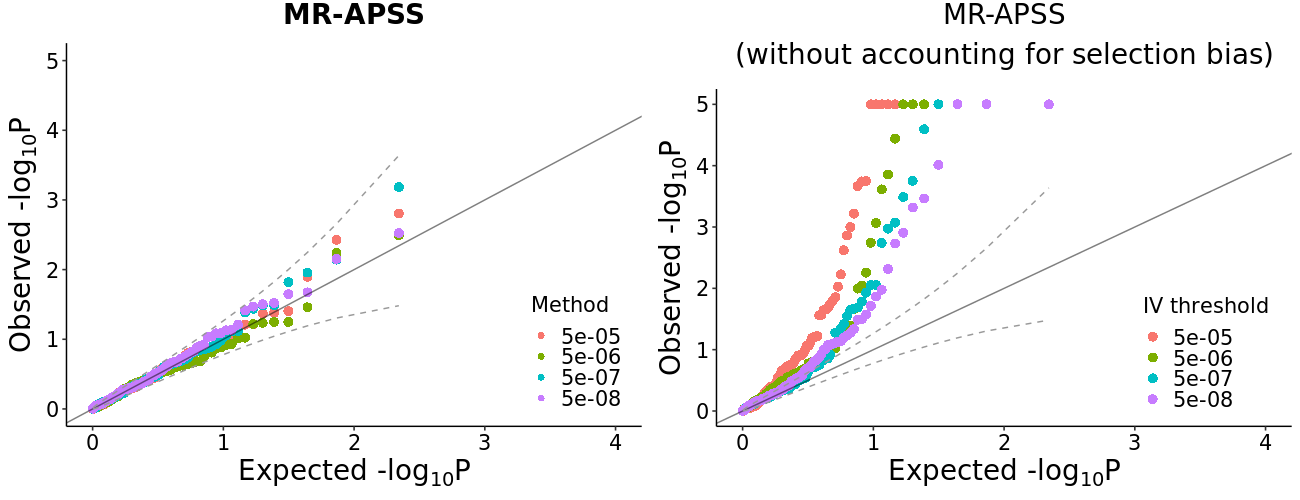

In [18]:
# Load packages
library(latex2exp)
library(gridExtra)
library(ggplot2)
library(ggpubr)

# Load QQ-plots functions
source('qqplot_funcs.R')


apss_res = read.table("NC_MRAPSS.MRres", header = F)
colnames(apss_res) = c("exposure","outcome", "nsnp","pi","nvalid","sigma.sq","tau.sq","b","se","pval",
                        "Method", "cor.Threshold", "IVstrength", "Threshold")
apss_res = subset(apss_res, Method %in% c("MR-APSS", "MR-APSS(Cor.SelectionBia=F)"))
apss_res_dcast = na.omit(reshape2::dcast(unique(apss_res), exposure + outcome ~ Method + Threshold, 
                                         value.var = "pval", drop = T))

qq.apss = qqplot4(apss_res_dcast, "MR-APSS_5e-05", "MR-APSS_5e-06","MR-APSS_5e-07","MR-APSS_5e-08",
                  comp.labels = c("5e-05","5e-06","5e-07","5e-08"),
                   max=5, strong = "MR-APSS_5e-05") +
  xlim(0,4) +
  ggtitle("MR-APSS") 

qq.apss_selecF = qqplot4(apss_res_dcast, "MR-APSS(Cor.SelectionBia=F)_5e-05", "MR-APSS(Cor.SelectionBia=F)_5e-06",
                                "MR-APSS(Cor.SelectionBia=F)_5e-07","MR-APSS(Cor.SelectionBia=F)_5e-08",
                  comp.labels = c("5e-05","5e-06","5e-07","5e-08"),
                  max=5) +
  xlim(0,4) +
  guides(colour = guide_legend("IV threshold")) +
  ggtitle(expression(atop("MR-APSS", "(without accounting for selection bias)"))) 
 
options(repr.plot.width = 13, repr.plot.height = 5, repr.plot.res = 100)
grid.arrange(qq.apss,qq.apss_selecF, layout_matrix = matrix(c(1,2), ncol =2, byrow = T))
